# __Projeto_2__

In this project, two challenges were proposed, the first challenge was to make prediction of sales for the weeks of October 2019.  
The second challenge was to retrieve insights from the data.

# Set up
In this section is present the setup for the rest of the notebook, libraries and functions used are present here

## Import libraries
All libraries used during this code are imported in this section 

In [225]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import sqrt
from geopy.geocoders import Nominatim
import datetime
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA
import holidays
import numpy as np
import csv
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
import warnings
warnings.filterwarnings("ignore")

## Functions used along the code

All the function used along the code are listed here

In [15]:
def get_city_population(city):
    url = 'https://en.wikipedia.org/wiki/List_of_largest_cities_and_towns_in_Turkey'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', class_='wikitable')
    rows = table.find_all('tr')[1:]  # Exclude the header row
    for row in rows:
        columns = row.find_all('td')
        if columns[1].text.strip() == city:
            population = columns[6].text.strip()
            return population
    return 'Population not found'

def latitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        latitude = location.latitude
        return latitude
    else:
        return "Latitude not found"
    
def longitude(city):
    geolocator = Nominatim(user_agent="my_app")
    location = geolocator.geocode(city)
    if location is not None:
        longitude = location.longitude
        return longitude
    else:
        return "Longitude not found"
    
def season(date):
    month = date.strftime('%B')
    day = date.day
    if month in ('January', 'February', 'March'):
        season = 'winter'
    elif month in ('April', 'May', 'June'):
        season = 'spring'
    elif month in ('July', 'August', 'September'):
        season = 'summer'
    else:
        season = 'autumn'
    if (month == 'March') and (day > 20):
        season = 'spring'
    elif (month == 'June') and (day > 20):
        season = 'summer'
    elif (month == 'September') and (day > 22):
        season = 'autumn'
    elif (month == 'December') and (day > 21):
        season = 'winter'
    return season

"""
def holidays(date):
    year = date.strftime('%Y')
    formated = date.strftime('%#d %B')
    url = 'https://en.wikipedia.org/wiki/Public_holidays_in_Turkey'
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find the table containing the holiday data
    table = soup.find_all('table', 'wikitable')[0]
    rows = table.find_all('tr')[1:]
    for row in rows:
        # Extract the cells of each row
        columns = row.find_all('td')
        if columns[0].text.strip() == formated:
            name = columns[1].text.strip()
            return name
    return 'Not Holiday'
"""

"\ndef holidays(date):\n    year = date.strftime('%Y')\n    formated = date.strftime('%#d %B')\n    url = 'https://en.wikipedia.org/wiki/Public_holidays_in_Turkey'\n    response = requests.get(url)\n    html_content = response.content\n    soup = BeautifulSoup(html_content, 'html.parser')\n\n    # Find the table containing the holiday data\n    table = soup.find_all('table', 'wikitable')[0]\n    rows = table.find_all('tr')[1:]\n    for row in rows:\n        # Extract the cells of each row\n        columns = row.find_all('td')\n        if columns[0].text.strip() == formated:\n            name = columns[1].text.strip()\n            return name\n    return 'Not Holiday'\n"

# Data cleaning

In this section some data cleaning will be performed. The city names were corrected, null values were replaced using the interpolate function of pandas, aswell as a k-nearest neighbors algorithm, for the first 2 csv files.  
For the third csv file, some columns were droped, and null values were filed.

## Product

In [38]:
product_df = pd.read_csv("product.csv")
product_df.shape
product_df.info()
print(product_df.duplicated().any())
# Check for nulls and replace missing values
print(product_df.isna().sum())
product_df["product_length"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_depth"].interpolate(method ='linear', limit_direction ='both', inplace=True)
product_df["product_width"].interpolate(method ='linear', limit_direction ='both', inplace=True)
print(product_df.isna().sum())

# Split the data into complete and missing
complete_data = product_df.dropna()
missing_data = product_df[product_df['cluster_id'].isnull()].drop('cluster_id', axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    complete_data[['product_length', 'product_depth', 'product_width']],
    complete_data['cluster_id'],
    test_size=0.2,
    random_state=42
)

# Perform K-nearest neighbors classification with hyperparameter tuning
parameters = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50],
    'p': [1, 2]
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, parameters, cv=5)
grid_search.fit(X_train, y_train)

# Best hyperparameters and model
best_k = grid_search.best_params_['n_neighbors']
best_weights = grid_search.best_params_['weights']
best_algorithm = grid_search.best_params_['algorithm']
best_leaf_size = grid_search.best_params_['leaf_size']
best_p = grid_search.best_params_['p']
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Predict clusters for missing data using the best model
missing_data['cluster_id'] = best_model.predict(missing_data[['product_length', 'product_depth', 'product_width']])

# Concatenate the complete data with the imputed missing data
result_df = pd.concat([complete_data, missing_data])

# Print the resulting DataFrame with clusters
print(result_df)
print(result_df.isna().sum())

result_df.to_csv("product_df.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      699 non-null    object 
 1   product_length  681 non-null    float64
 2   product_depth   683 non-null    float64
 3   product_width   683 non-null    float64
 4   cluster_id      649 non-null    object 
 5   hierarchy1_id   699 non-null    object 
 6   hierarchy2_id   699 non-null    object 
 7   hierarchy3_id   699 non-null    object 
 8   hierarchy4_id   699 non-null    object 
 9   hierarchy5_id   699 non-null    object 
dtypes: float64(3), object(7)
memory usage: 54.7+ KB
False
product_id         0
product_length    18
product_depth     16
product_width     16
cluster_id        50
hierarchy1_id      0
hierarchy2_id      0
hierarchy3_id      0
hierarchy4_id      0
hierarchy5_id      0
dtype: int64
product_id         0
product_length     0
product_depth      0
product_wi

## Sales

In [12]:
sales_df = pd.read_csv("sales.csv")
sales_df = sales_df[sales_df["date"] < "2019-09-30"]
# We chose data before 30 of september because it is a monday and the first week of october

sales_df = sales_df.drop(sales_df.columns[0], axis=1)
print(sales_df.isna().sum())
print(len(sales_df))

#fill the price
sales_df['price'] = sales_df.groupby('product_id')['price'].transform(lambda x: x.fillna(x.mean()))
print(sales_df.isna().sum())
#after this some nulls still remain, that means that the dataset contains products for which there isnt a price in any place

#drop columns with a lot of nulls
sales_df.drop(['promo_bin_2', 'promo_discount_2', 'promo_discount_type_2'], axis=1, inplace=True)

#count distinct values of a column
value_counts = sales_df['promo_type_2'].value_counts()
print(value_counts)

# Given that less than one percent of the data related to promo_type_2 is different from the majority of the values
# we will drop this column aswell
sales_df.drop(['promo_type_2'], axis=1, inplace=True)

value_counts = sales_df['promo_type_1'].value_counts()
print(value_counts)

value_counts = sales_df['promo_bin_1'].value_counts()
print(value_counts)

sales_df['promo_bin_1'].fillna("none", inplace=True)

#binary_cols = pd.get_dummies(sales_df['promo_bin_1'], prefix='promo_bin_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#binary_cols = pd.get_dummies(sales_df['promo_type_1'], prefix='promo_type_')
#sales_df = pd.concat([sales_df, binary_cols], axis=1)

#sales_df.drop(['promo_type_1', 'promo_bin_1'], axis=1, inplace=True)

# Assignin a value to the remaing null values of the price to 0 because we dont want to lose the rest of the information
# its around 7000 so less then 1% see after model if it affects a lot, and wew dont want to lose entire values because of the price

#sales_df.dropna(inplace=True)
sales_df['price'].fillna("0", inplace=True)
print(sales_df.isna().sum())

sales_df.head()
print(len(sales_df))
sales_df.to_csv("sales_df.csv", index=False)

store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                      89354
promo_type_1                   0
promo_bin_1              7393924
promo_type_2                   0
promo_bin_2              8565802
promo_discount_2         8565802
promo_discount_type_2    8565802
dtype: int64
8574076
store_id                       0
product_id                     0
date                           0
sales                          0
revenue                        0
stock                          0
price                       6617
promo_type_1                   0
promo_bin_1              7393924
promo_type_2                   0
promo_bin_2              8565802
promo_discount_2         8565802
promo_discount_type_2    8565802
dtype: int64
PR03    8565802
PR02       6088
PR01       2098
PR04         88
Name: promo_type_2, dtype: int64
PR14    739

## Cities

In [13]:
cities_df = pd.read_csv("cities.csv")
cities_df['city_code'] = cities_df['city_code'].str.replace('?', 'i')
cities_df['city_code'] = cities_df['city_code'].str.replace('Sanliurfa', 'Şanlıurfa')
cities_df['city_code'] = cities_df['city_code'].str.replace('Izmir', 'İzmir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Diyarbakir', 'Diyarbakır')
cities_df['city_code'] = cities_df['city_code'].str.replace('Eskiiehir', 'Eskişehir')
cities_df['city_code'] = cities_df['city_code'].str.replace('Adapazari', 'Adapazarı')
cities_df['city_code'] = cities_df['city_code'].str.replace('Kahramanmaras', 'Kahramanmaraş')
cities_df['city_code'] = cities_df['city_code'].str.title()

In [16]:
# Add a new column to store population
cities_df['Population'] = cities_df['city_code'].apply(get_city_population)
cities_df['Latitude'] = cities_df['city_code'].apply(latitude)
cities_df['Longitude'] = cities_df['city_code'].apply(longitude)

print(cities_df)

#It doesnt work for Izmir so replace manually
cities_df['Population'] = cities_df['Population'].str.replace('Population not found', '2,847,691')

# remove the commas
cities_df['Population'] = cities_df['Population'].str.replace(',', '')

cities_df.to_csv("cities_df.csv", index=False)

   store_id storetype_id  store_size city_id_old country_id      city_code  \
0     S0036         ST04          21        C001     TURKEY        Denizli   
1     S0005         ST04          19        C001     TURKEY        Denizli   
2     S0104         ST04          47        C002     TURKEY         Ankara   
3     S0068         ST03          14        C003     TURKEY          Izmir   
4     S0086         ST03          12        C003     TURKEY          Izmir   
..      ...          ...         ...         ...        ...            ...   
58    S0040         ST04          42        C017     TURKEY  Kahramanmaraş   
59    S0046         ST04          26        C017     TURKEY  Kahramanmaraş   
60    S0102         ST04          27        C018     TURKEY        Erzurum   
61    S0032         ST03          14        C019     TURKEY            Van   
62    S0061         ST04          35        C019     TURKEY            Van   

              Population   Latitude  Longitude  
0             

## External data  
Some data was already aggreagated in the previous cells, here some more will be extracted

In [42]:
# Define the start and end dates
start_date = date(2017, 1, 1)
end_date = date(2019, 12, 1)

# Create a list of dates
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# Create a DataFrame
df_1 = pd.DataFrame(date_list, columns=['Date'])
df_1['season'] = df_1['Date'].apply(season)

# Get the list of holidays for Turkey
holiday_list = []
for single_date in (start_date + timedelta(n) for n in range((end_date - start_date).days + 1)):
    holidays_data = holidays.Turkey(years=single_date.year).get(single_date)
    if holidays_data is not None:
        holiday_list.append((single_date, holidays_data))

# Create a DataFrame from the list of holidays
df = pd.DataFrame(holiday_list, columns=['Date', 'Holiday'])

# Print the DataFrame
print(df)

merged_df = pd.merge(df_1, df, on='Date', how='left')
print(merged_df)

#change some values manually
merged_df.to_csv("season_holidays.csv", index=False)

          Date                                         Holiday
0   2017-01-01                                  New Year's Day
1   2017-04-23         National Sovereignty and Children's Day
2   2017-05-01                                      Labour Day
3   2017-05-19  Commemoration of Ataturk, Youth and Sports Day
4   2017-06-25                     Ramadan Feast* (*estimated)
5   2017-06-26             Ramadan Feast Holiday* (*estimated)
6   2017-06-27             Ramadan Feast Holiday* (*estimated)
7   2017-07-15                Democracy and National Unity Day
8   2017-08-30                                     Victory Day
9   2017-09-01                   Sacrifice Feast* (*estimated)
10  2017-09-02           Sacrifice Feast Holiday* (*estimated)
11  2017-09-03           Sacrifice Feast Holiday* (*estimated)
12  2017-09-04           Sacrifice Feast Holiday* (*estimated)
13  2017-10-29                                    Republic Day
14  2018-01-01                                  New Yea

# Data Analytics
Some graphs that main retrieve insights from the data are present in this section

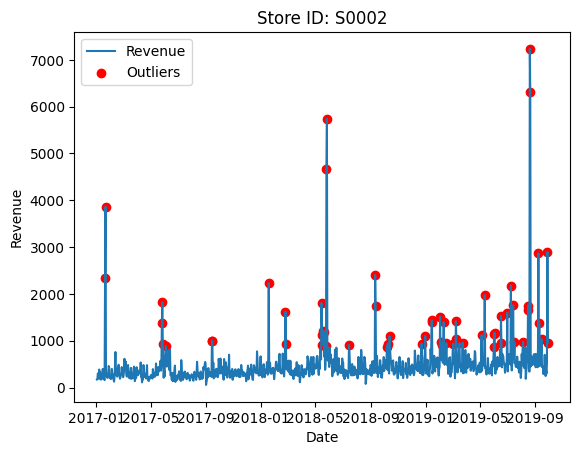

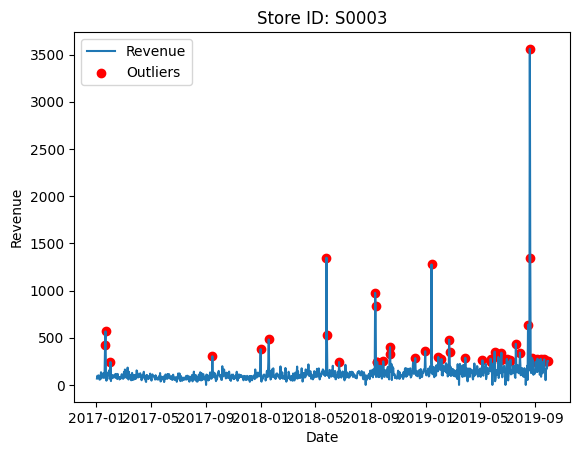

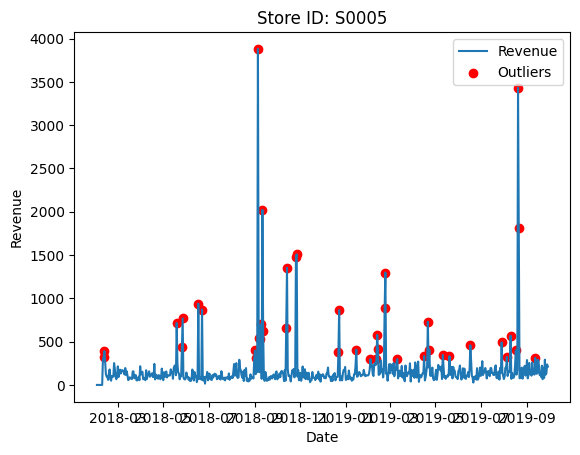

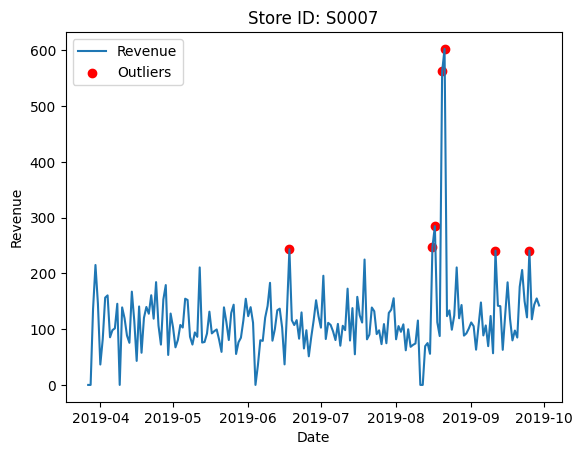

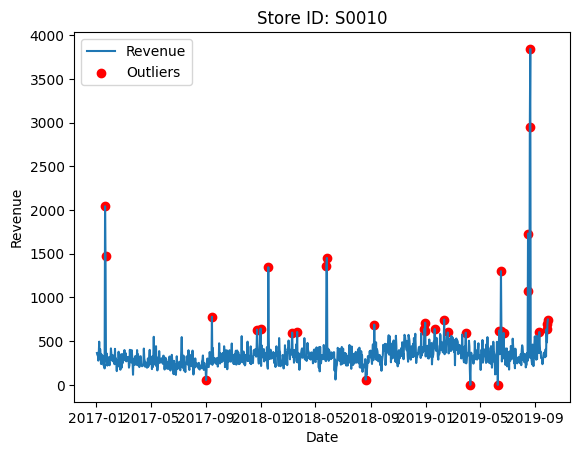

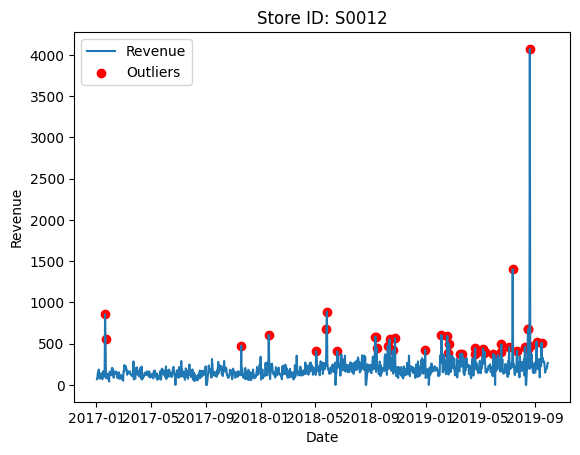

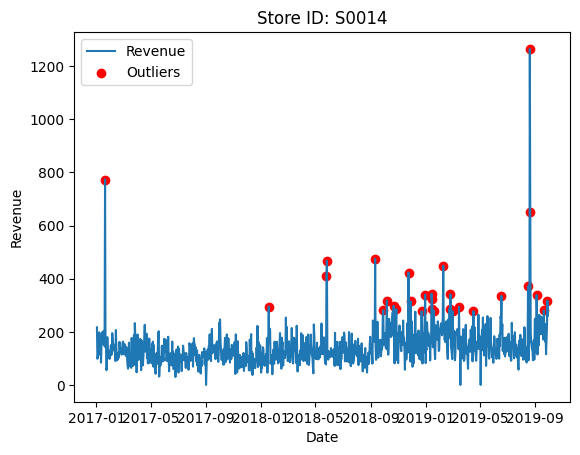

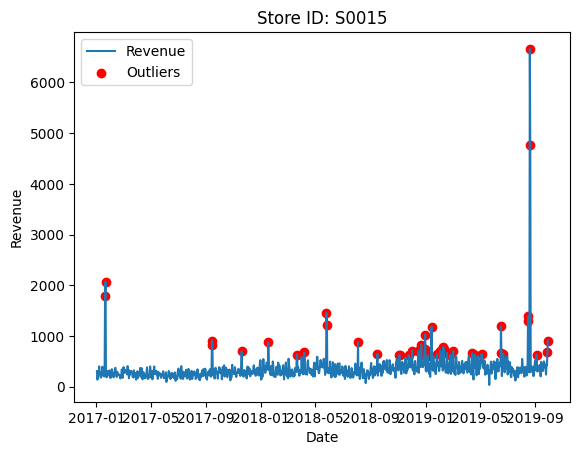

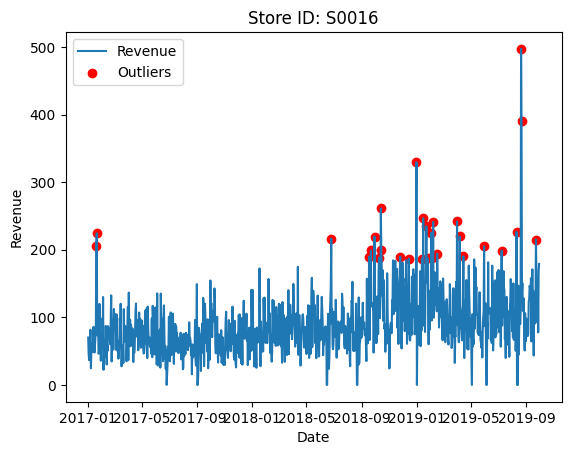

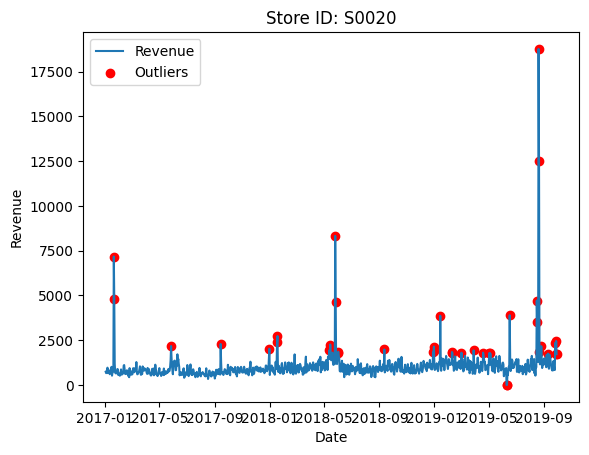

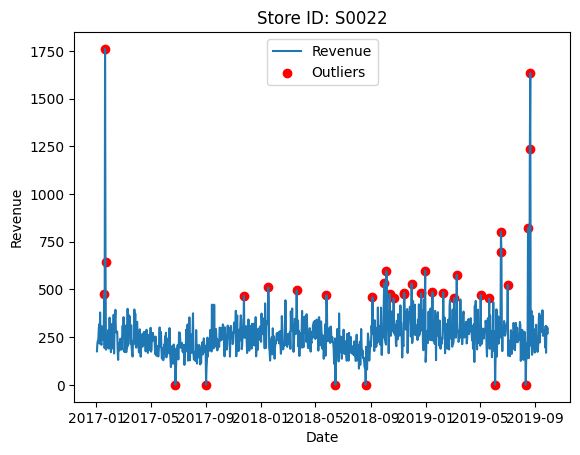

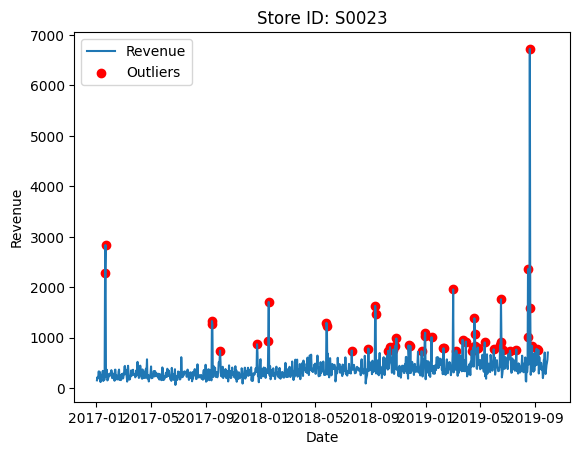

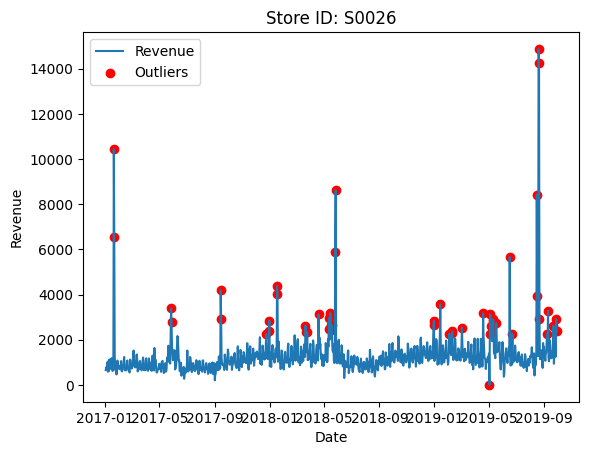

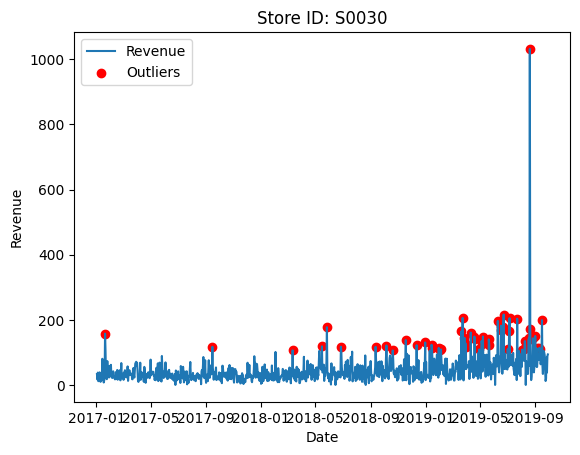

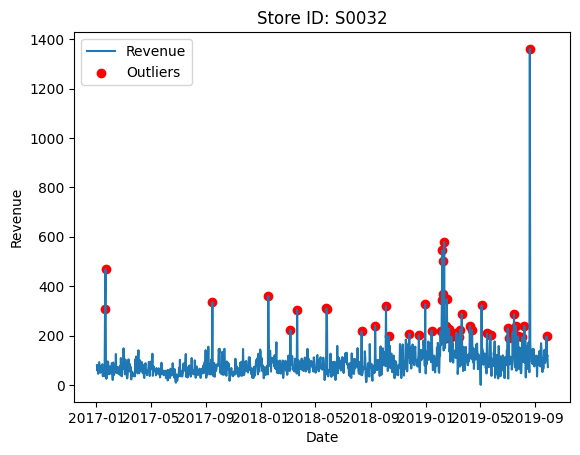

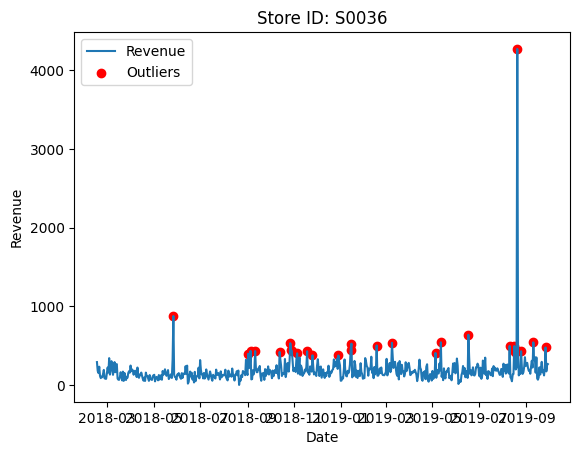

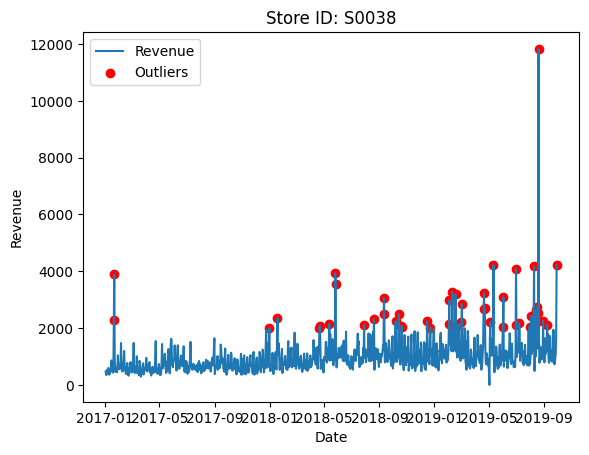

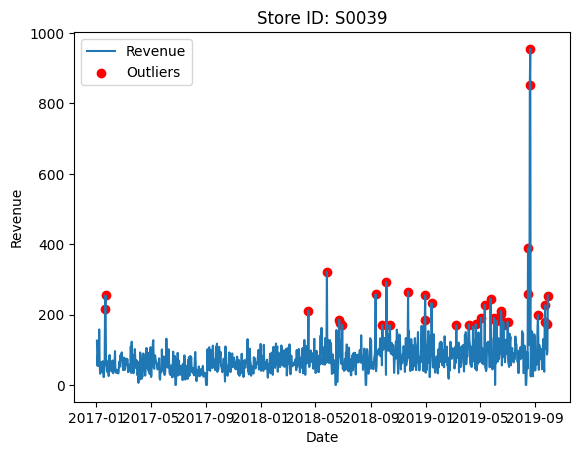

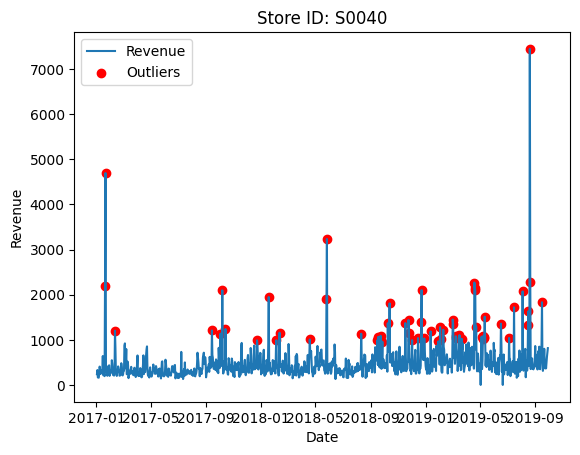

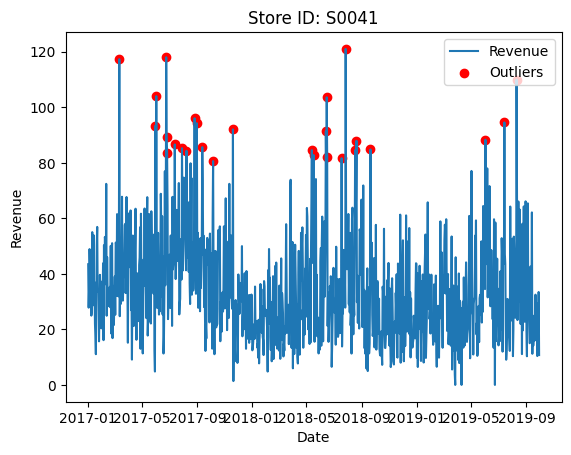

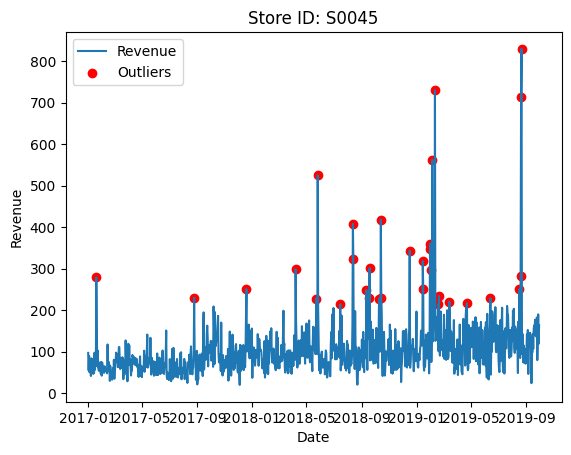

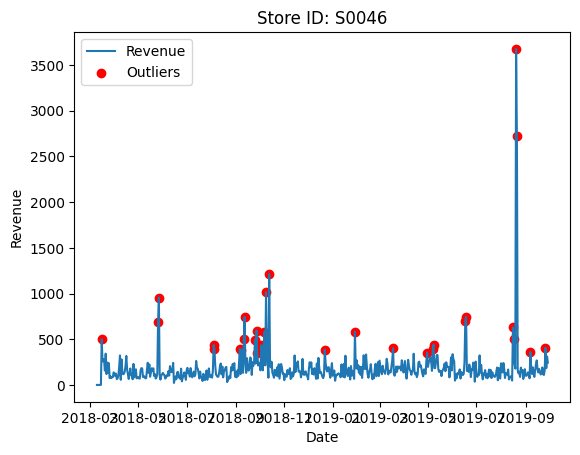

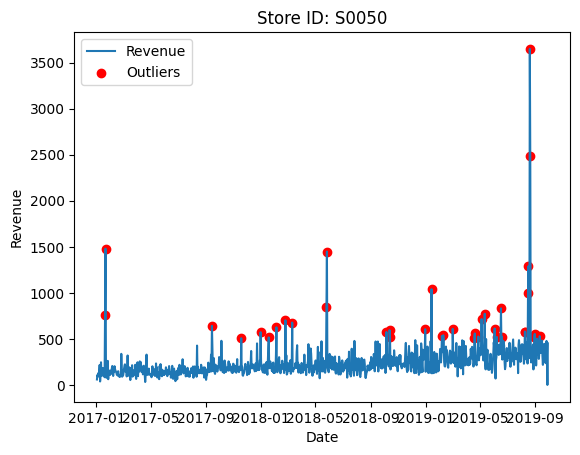

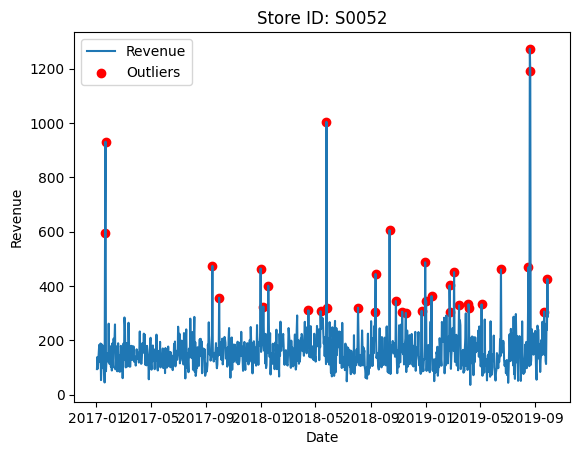

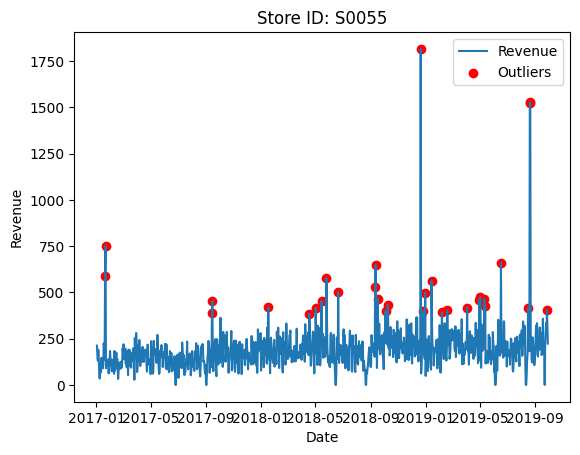

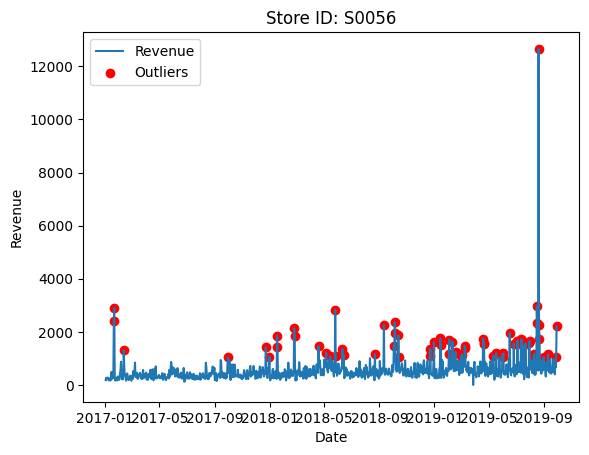

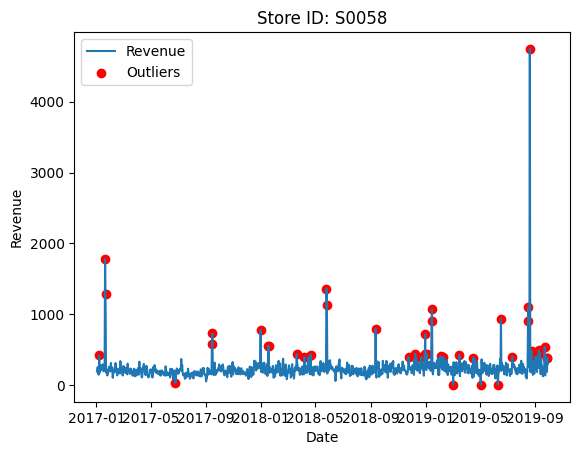

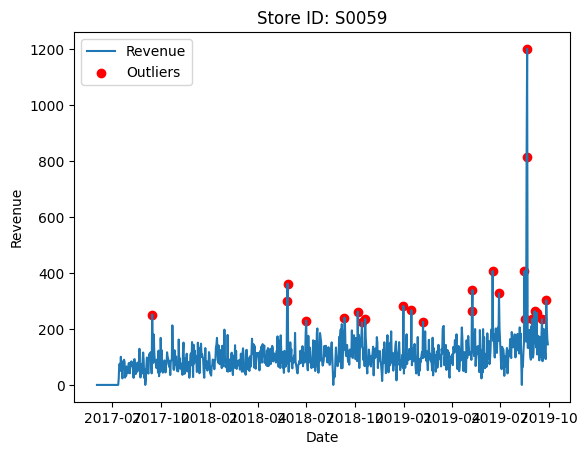

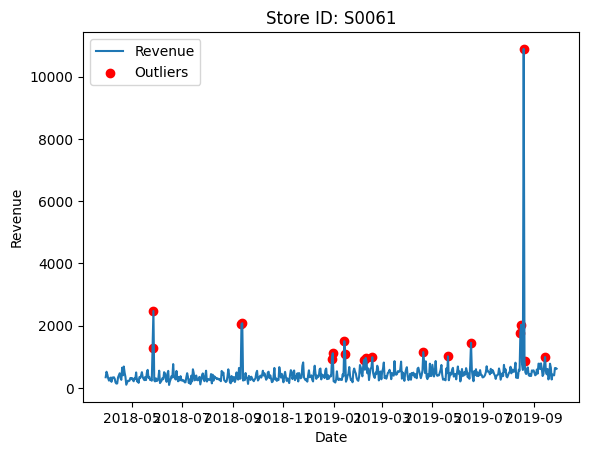

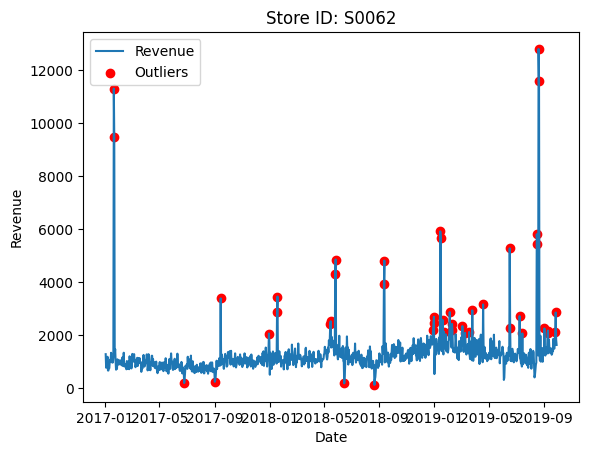

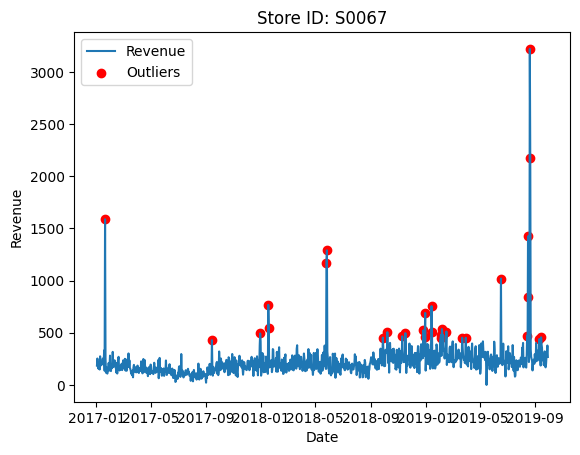

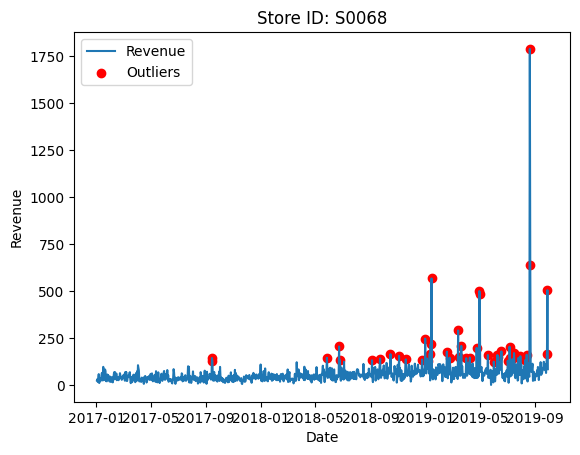

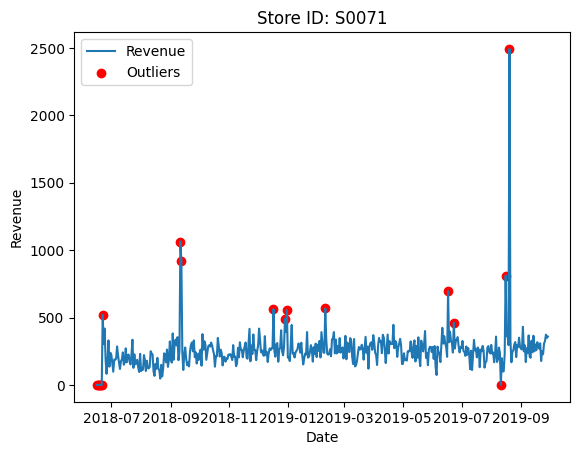

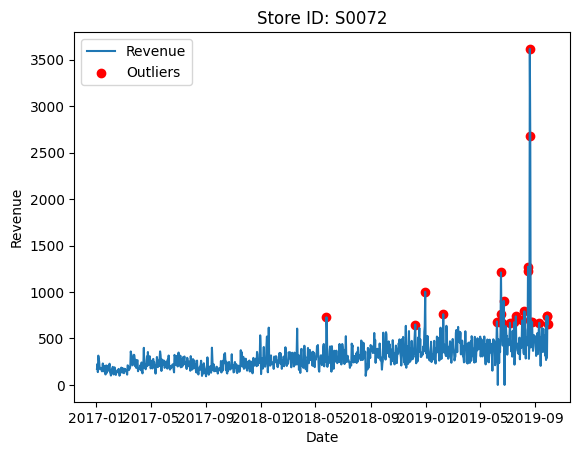

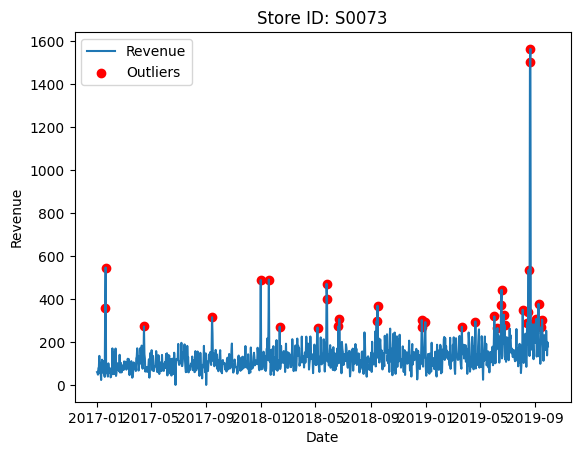

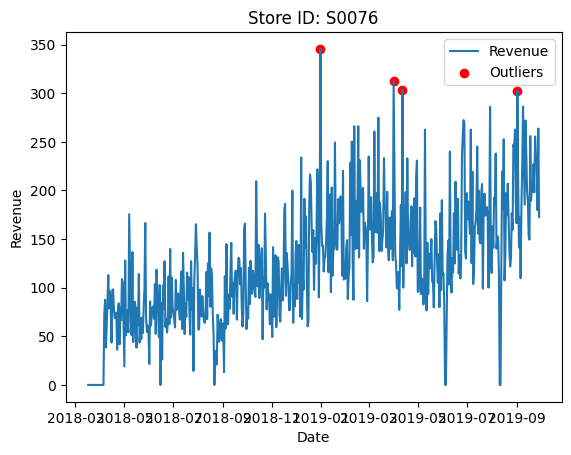

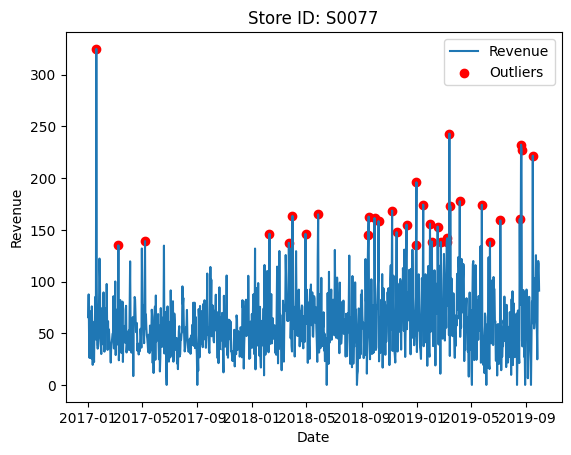

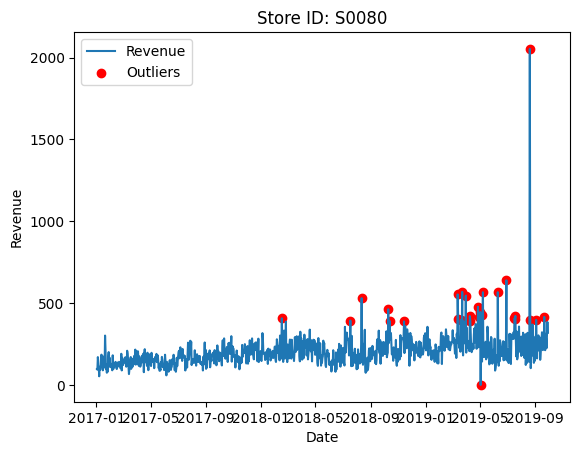

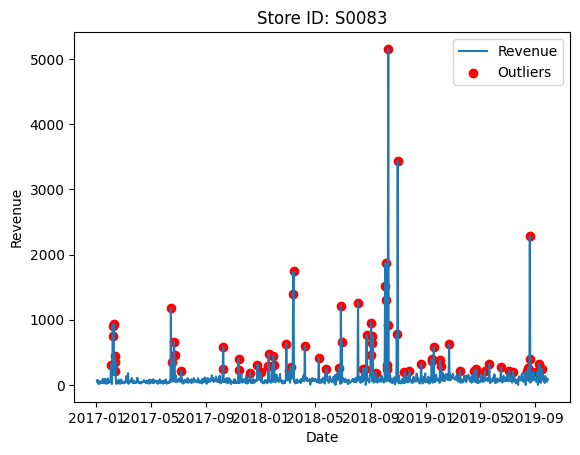

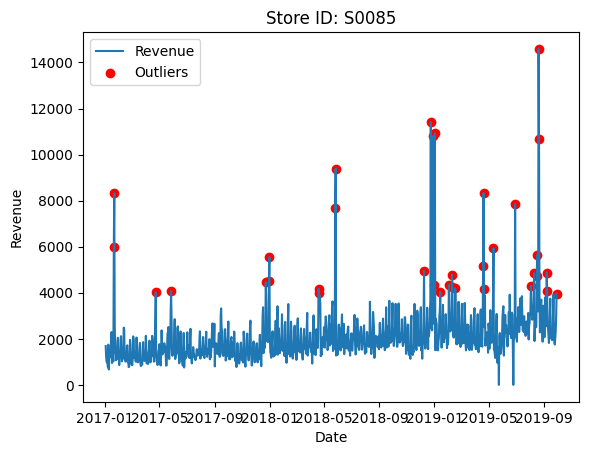

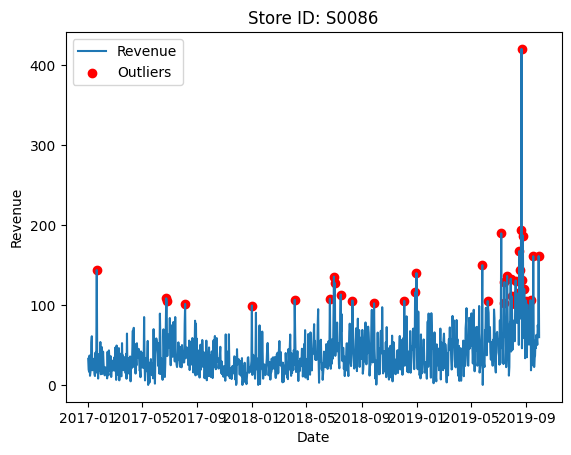

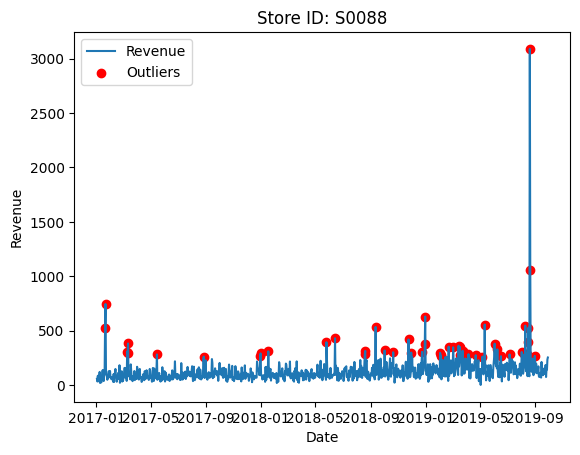

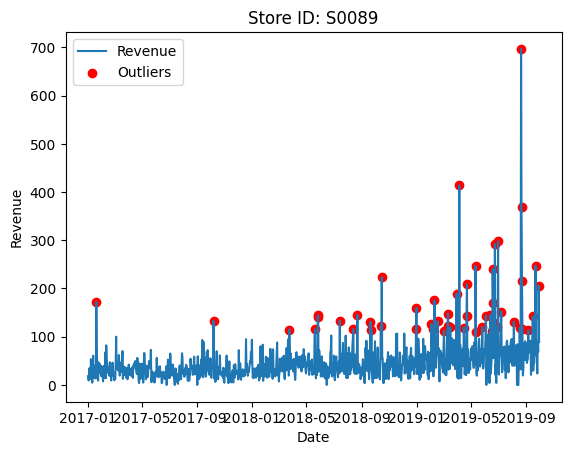

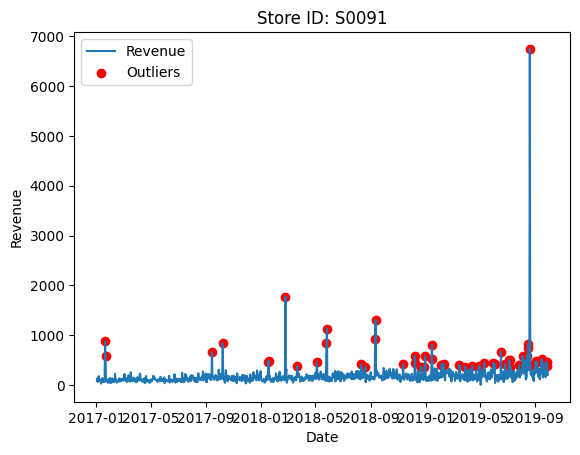

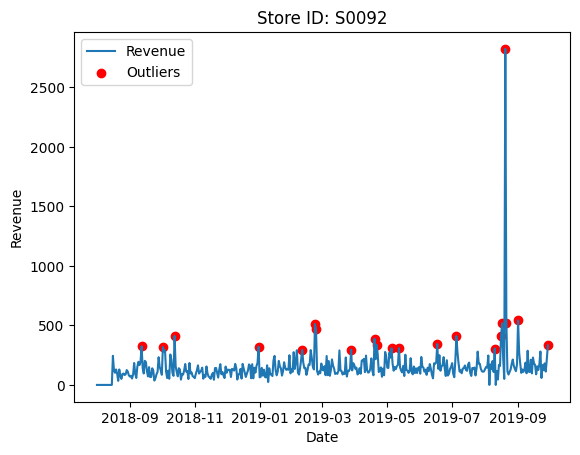

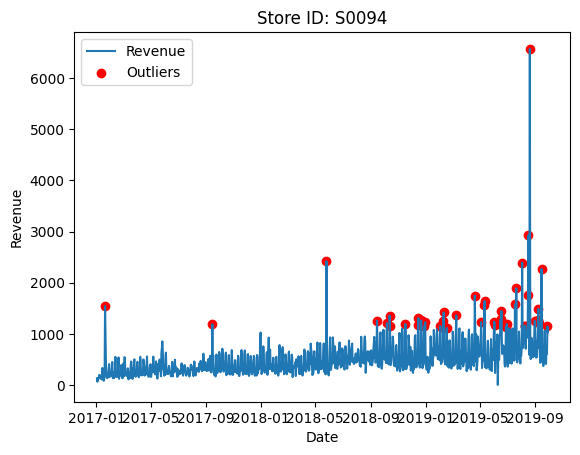

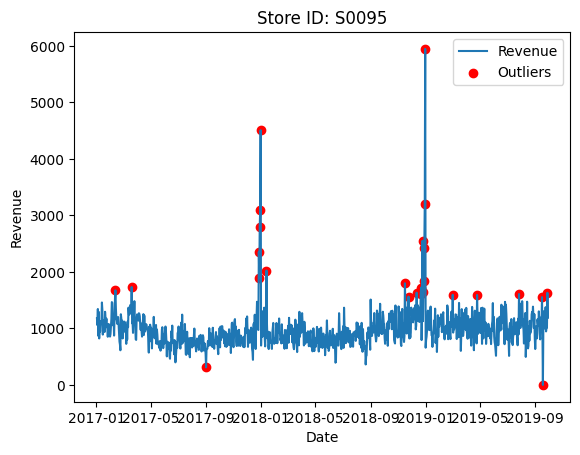

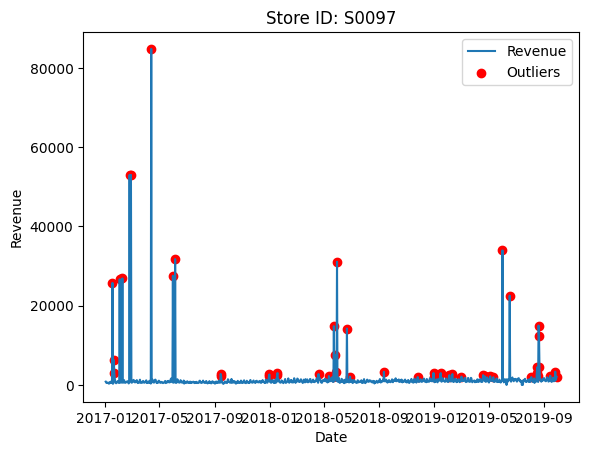

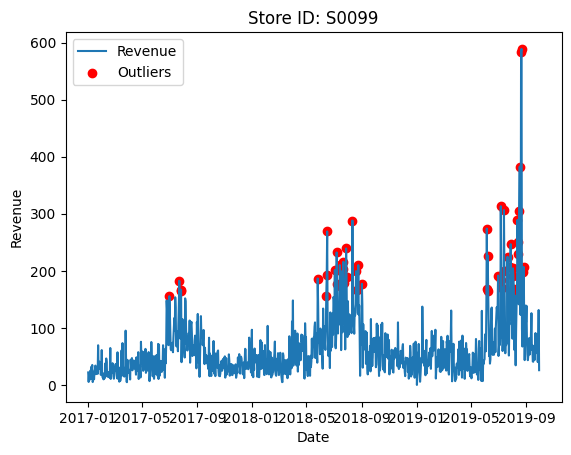

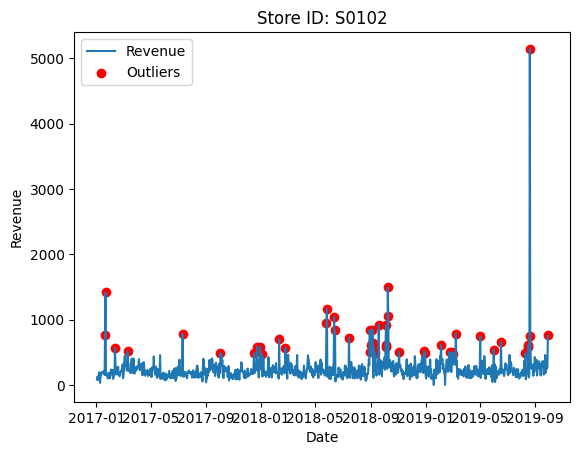

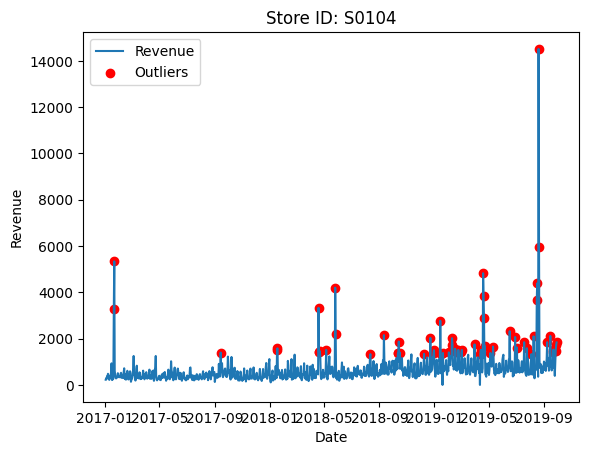

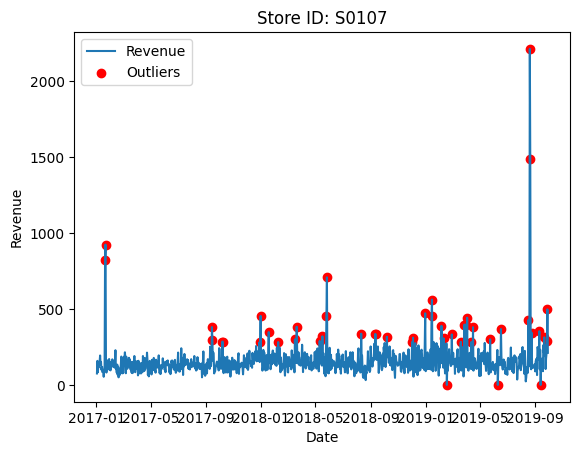

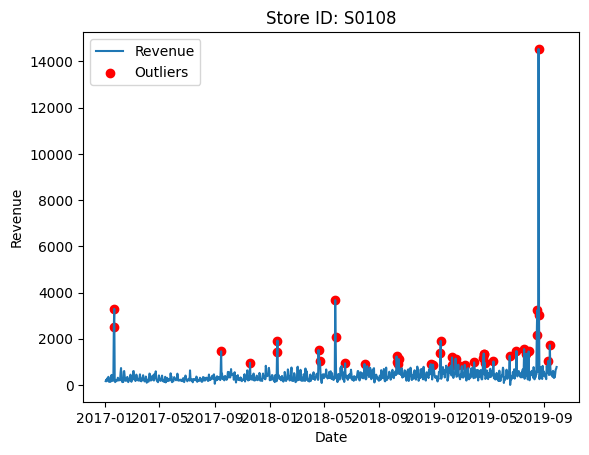

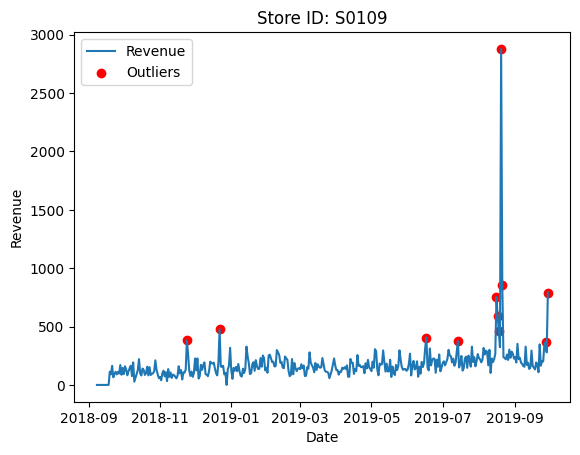

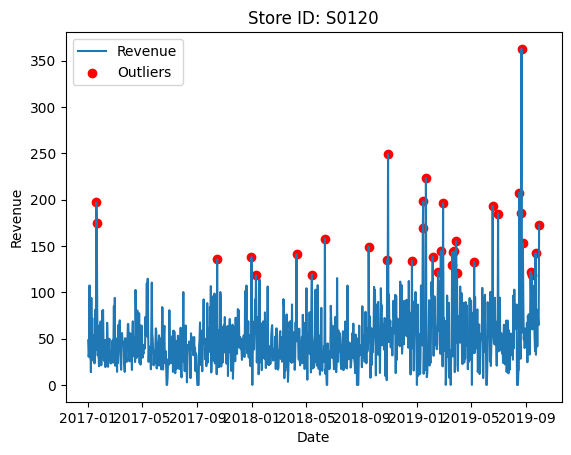

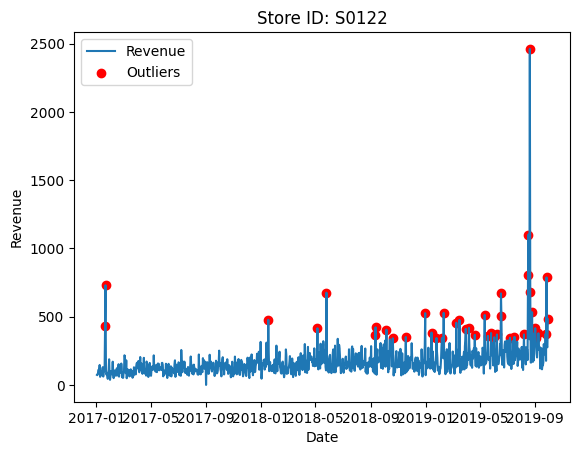

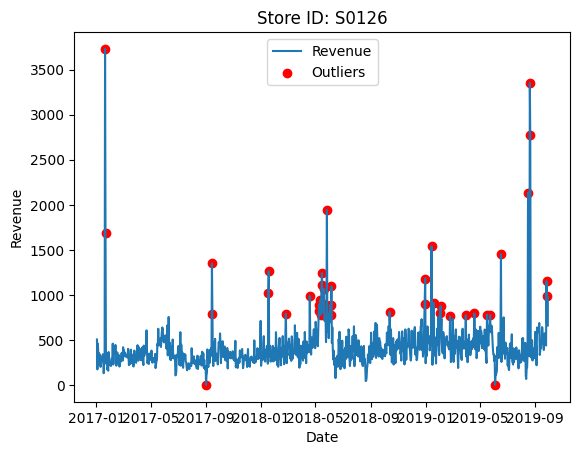

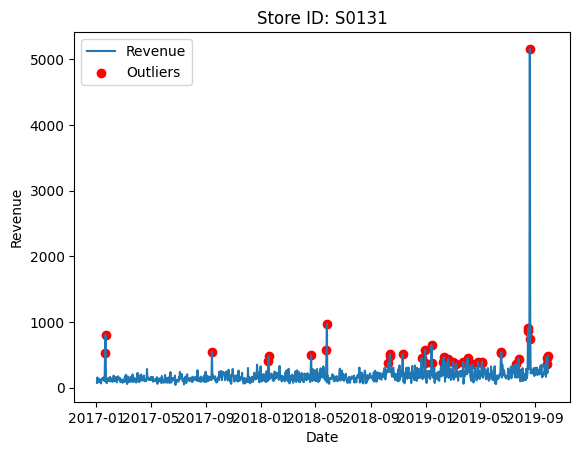

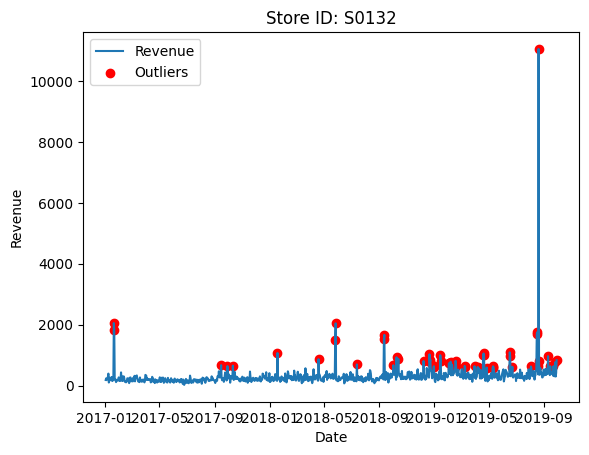

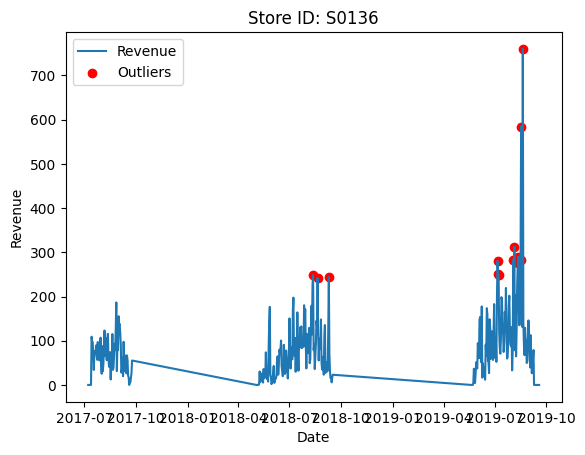

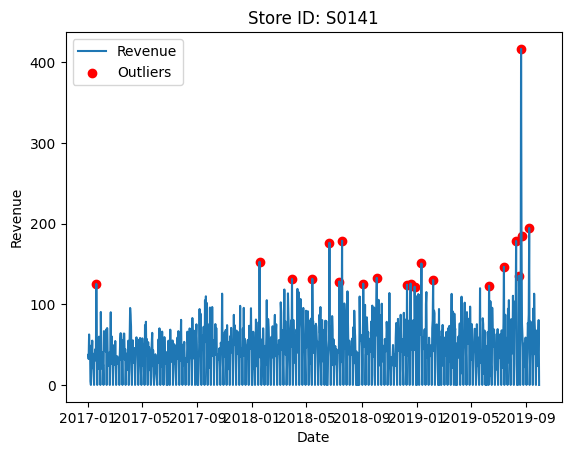

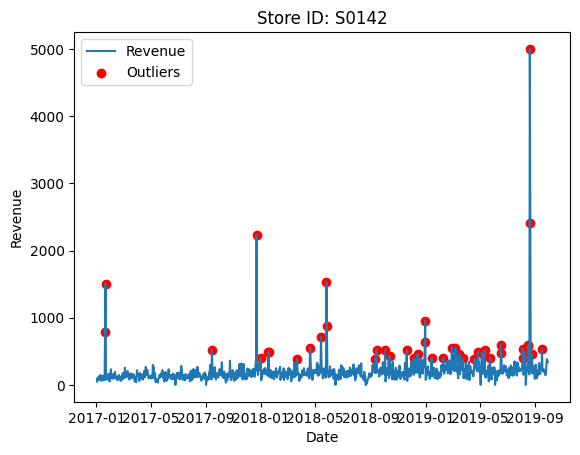

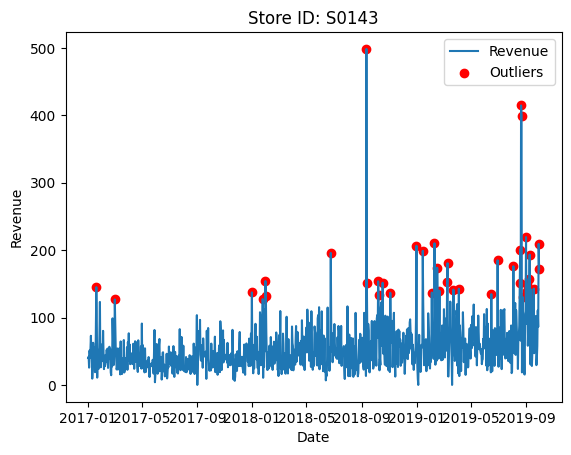

In [16]:
df = pd.read_csv('sales_df.csv')
df['date'] = pd.to_datetime(df['date'])
aggregated_df = df.groupby(['date', 'store_id']).agg({'revenue': 'sum'}).reset_index()

grouped_df = aggregated_df.groupby('store_id')
for store_id, group_data in grouped_df:
    # Calculate the IQR
    Q1 = group_data['revenue'].quantile(0.25)
    Q3 = group_data['revenue'].quantile(0.75)
    IQR = Q3 - Q1

    # Determine the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = group_data[(group_data['revenue'] < lower_bound) | (group_data['revenue'] > upper_bound)]

    # Plot the data with outliers highlighted
    plt.figure()
    plt.plot(group_data['date'], group_data['revenue'], label='Revenue')
    plt.scatter(outliers['date'], outliers['revenue'], color='red', label='Outliers')
    plt.title(f"Store ID: {store_id}")
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()

# Modelling
In this section is where the entire modeling occurs it also includes some data understanding and preparation

## Data understanding

In here we want to verify if our data is good, we have replaced null values and cleaned the data before, but in this section we want to check if there is the correct number of weeks in each year if we are missing some years among other things

In [9]:
df = pd.read_csv("sales_df.csv")
print(df)
df['date'] = pd.to_datetime(df['date'])
grouped_df = df.groupby([pd.Grouper(key='date', freq="W-SUN"), 'store_id']).agg({'revenue': 'sum'}).reset_index()
print(grouped_df)
# Count the number of weeks in each year for each store
week_counts = grouped_df.groupby(['store_id', grouped_df['date'].dt.year]).size().reset_index(name='week_count')
print(week_counts)
week_counts.to_csv("week_counts.csv", index=False)

# Add years present
year_present = grouped_df.groupby('store_id')['date'].apply(lambda x: x.dt.year.unique()).reset_index(name='year_present')
week_counts = week_counts.merge(year_present, on='store_id', how='left')

# Count the number of times a store appears
store_counts = week_counts['store_id'].value_counts().reset_index().rename(columns={'store_id': 'count'})
print(store_counts)

week_counts.to_csv("week_counts.csv", index=False)
store_counts.to_csv("store_counts.csv", index=False)

filtered_week_counts = week_counts[(week_counts['week_count'] < 52) & (week_counts['date'] < 2019)]
print(filtered_week_counts)
filtered_store_counts = store_counts[(store_counts['count'] < 3)]
print(filtered_store_counts)

last_dates = grouped_df.groupby('store_id')['date'].max().reset_index(name='last_date')
last_dates.to_csv("last_dates.csv")
# We notice that there is missing data in a lot of stores, some dont have all weeks of the year in some others complete years are missing

print(last_dates)

        store_id product_id        date  sales  revenue  stock  price  \
0          S0002      P0001  2017-01-02    0.0     0.00    8.0   6.25   
1          S0002      P0005  2017-01-02    0.0     0.00   11.0  33.90   
2          S0002      P0011  2017-01-02    0.0     0.00    9.0  49.90   
3          S0002      P0015  2017-01-02    1.0     2.41   19.0   2.60   
4          S0002      P0017  2017-01-02    0.0     0.00   12.0   1.49   
...          ...        ...         ...    ...      ...    ...    ...   
8574071    S0143      P0694  2019-09-29    0.0     0.00    7.0   7.50   
8574072    S0143      P0709  2019-09-29    0.0     0.00    7.0   7.00   
8574073    S0143      P0711  2019-09-29    0.0     0.00    5.0  12.90   
8574074    S0143      P0718  2019-09-29    0.0     0.00   14.0  23.75   
8574075    S0143      P0747  2019-09-29    0.0     0.00    3.0  21.90   

        promo_type_1 promo_bin_1  
0               PR14        none  
1               PR14        none  
2               PR

In [12]:
# Load the dataset
df = pd.read_csv("sales_df.csv")
df['date'] = pd.to_datetime(df['date'])
stores = df['store_id'].unique()

# Iterate over each store
for store in stores:
    # Filter the dataset for the current store
    store_data = df[df['store_id'] == store]
    
    # Create a date range for the store
    min_date = store_data['date'].min()
    max_date = store_data['date'].max()
    date_range = pd.date_range(start=min_date, end=max_date)
    
    # Check for missing dates for the store
    missing_dates = date_range[~date_range.isin(store_data['date'])]
    
    # Print the missing dates for the store
    if len(missing_dates) > 0:
        print("Missing dates for store", store, ":")
        print(missing_dates)
    else:
        print("Data is available for every day for store", store)

Data is available for every day for store S0002
Data is available for every day for store S0003
Data is available for every day for store S0005
Data is available for every day for store S0007
Data is available for every day for store S0010
Data is available for every day for store S0012
Data is available for every day for store S0014
Data is available for every day for store S0015
Data is available for every day for store S0016
Data is available for every day for store S0020
Data is available for every day for store S0022
Data is available for every day for store S0023
Data is available for every day for store S0026
Data is available for every day for store S0030
Data is available for every day for store S0032
Data is available for every day for store S0036
Data is available for every day for store S0038
Data is available for every day for store S0039
Data is available for every day for store S0040
Data is available for every day for store S0041
Data is available for every day for stor

In [20]:
df = pd.read_csv("sales_df.csv")
df['date'] = pd.to_datetime(df['date'])
stores = df['store_id'].unique()

# Group the data by store and weekly frequency, summing the revenue
grouped_df1 = df.groupby(['store_id', pd.Grouper(key='date', freq='W-SUN')]).agg({'revenue': 'sum'}).reset_index()
grouped_df = grouped_df1[grouped_df1['revenue'] < 0]
print(grouped_df)
grouped_df = grouped_df1[grouped_df1['revenue'] == 0]
print(grouped_df)

Empty DataFrame
Columns: [store_id, date, revenue]
Index: []
     store_id       date  revenue
286     S0005 2018-02-04      0.0
2773    S0046 2018-03-11      0.0
3570    S0059 2017-06-04      0.0
3571    S0059 2017-06-11      0.0
3572    S0059 2017-06-18      0.0
3573    S0059 2017-06-25      0.0
3574    S0059 2017-07-02      0.0
3575    S0059 2017-07-09      0.0
4200    S0071 2018-06-17      0.0
4554    S0076 2018-03-18      0.0
4555    S0076 2018-03-25      0.0
4556    S0076 2018-04-01      0.0
5779    S0092 2018-08-05      0.0
5780    S0092 2018-08-12      0.0
6984    S0109 2018-09-09      0.0
6985    S0109 2018-09-16      0.0
7755    S0136 2017-07-09      0.0
7767    S0136 2018-05-06      0.0
7787    S0136 2019-05-19      0.0
7804    S0136 2019-09-15      0.0
7805    S0136 2019-09-22      0.0


In [17]:
df = pd.read_csv("sales_df.csv")
df['date'] = pd.to_datetime(df['date'])

# Calculate average revenue for a specific date
target_date = pd.to_datetime('2017-03-01')
average_revenue = df[df['date'] == target_date]['revenue'].mean()

# Create a new row with average revenue
new_row = pd.DataFrame({'date': [target_date], 'revenue': [average_revenue]})

# Append the new row to the dataframe
df = df.append(new_row, ignore_index=True)
print(df.isna().sum())
# we are expecting 1 null in each of the other columns it doesnt 
# really matter because we are not going to use the remaining data for now, but we are going to fill those values

# Replace null values with the average revenue
df['store_id'].fillna('S0072', inplace=True)
df['price'].fillna('0', inplace=True)
df['stock'].fillna('0', inplace=True)
df['sales'].fillna('0', inplace=True)

columns_to_fill = ['promo_type_1', 'promo_bin_1', 'product_id']

# Replace null values in the specified columns with the most common value in each column
for column in columns_to_fill:
    most_common_value = df[column].value_counts().idxmax()
    df[column].fillna(most_common_value, inplace=True)

print(df.isna().sum())
df = df.sort_values(['store_id', 'date'])
df.to_csv("sales_df_final.csv", index=False)

store_id        1
product_id      1
date            0
sales           1
revenue         0
stock           1
price           1
promo_type_1    1
promo_bin_1     1
dtype: int64
store_id        0
product_id      0
date            0
sales           0
revenue         0
stock           0
price           0
promo_type_1    0
promo_bin_1     0
dtype: int64


### Conclusions of this small analisys
The following stores only have information of 2 years and  the amount of data in each year  
To these stores we need to check if they only opened in 2018 and if so check that all the weeks are present  
S0005 [2018 2019] 48 39  
S0036 [2018 2019] 46 39  
S0046 [2018 2019] 43 39  
S0061 [2018 2019] 40 39  
S0071 [2018 2019] 29 39  
S0076 [2018 2019] 42 39  
S0092 [2018 2019] 22 39  
S0109 [2018 2019] 17 39  
  
The following store only has information of 1 year  
S0007 [2019] 27  

In addition to the ones before here we are displaying other stores that are missing some weeks of information eventhough there is information for the 3 years  
S0059  [2017 2018 2019] 31 52 39  
S0136  [2017 2018 2019] 12 20 19  
  
We also want to predict to the first week of October and the following store has the last information until 22 of September
S0136 2019-09-22  
  
However we are supposed to have 39 weeks in the year of 2019 because we are trying to predict the next 5 weeks 
  
However in the remaining cases there is a real problem of prediction because for a time series analysis if we defined the seasonality as 52 weeks we need atleat 104 observations to be given a prediction which is data that we dont have because we are missing entire years.  

In this analysis we have gained even more insights on the data, we have checked that there is only 2 stores with missing dates which is good, because that means that all stores for which we don't have data since 02 January 2017 opened later then that, and it giver more insights on store S0059 that it just opened later in 2017 and doesnt have missing data.  

The stores that have missing data are stores S0136, and S0072.  

For store S0136 this was expected already.  
For store S0072 there is only one day missing, therefore we will replace it with the average of the revenue for the store  

By this analysis excluding the store S0136, we can infer that the stores that opened more recently have weeks in wich their revenue is 0, later we can verify more thorougly when this happens, for now we speculate that it might be in the weeks of the opening

## Complete data

### Data Prepatation

In [109]:
df = pd.read_csv("sales_df_final.csv")
stores_to_delete = ["S0005", "S0036", "S0046", "S0061", "S0071", "S0076", "S0092", "S0109", "S0007", "S0059", "S0136"]
df_1 = df[~df['store_id'].isin(stores_to_delete)]
df_2 = df[df['store_id'].isin(stores_to_delete)]
df_1['date'] = pd.to_datetime(df_1['date'])
df_2['date'] = pd.to_datetime(df_2['date'])

In [110]:
# Step 1: Group the data by store and week
grouped_df = df_1.groupby([pd.Grouper(key='date', freq='W-SUN'), 'store_id']).agg({'revenue': 'sum'}).reset_index()
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
grouped_df['month'] = grouped_df.date.dt.month
grouped_df['weekofyear'] = grouped_df['date'].dt.isocalendar().week
grouped_df['is_open'] = 0
# Set 'is_open' to 1 for days where sales data is not 0
grouped_df.loc[grouped_df['revenue'] != 0, 'is_open'] = 1

# Step 2 Read other file to add information
season_holidays = pd.read_csv("season_holidays.csv")
season_holidays = season_holidays.rename(columns={'Date': 'date'})
season_holidays['date'] = pd.to_datetime(season_holidays['date'])

# Group by week and create binary columns
season_holidays = season_holidays.groupby(by=pd.Grouper(key='date', freq='W-SUN')).agg({
    'season': lambda x: ','.join(set(x)),
    'Holiday': 'any'
}).reset_index()

# Create binary columns for seasons
season_holidays['IsWinter'] = season_holidays['season'].str.contains('winter').astype(int)
season_holidays['IsSummer'] = season_holidays['season'].str.contains('summer').astype(int)
season_holidays['IsSpring'] = season_holidays['season'].str.contains('spring').astype(int)
season_holidays['IsAutumn'] = season_holidays['season'].str.contains('autumn').astype(int)

# Create binary columns for holidays
season_holidays['IsHoliday'] = season_holidays['Holiday'].astype(int)

# Shift the holiday column by 1 week to get last week's holiday
season_holidays['LastWeekHoliday'] = season_holidays['Holiday'].shift(1).fillna(False).astype(int)

# Shift the holiday column by -1 week to get next week's holiday
season_holidays['NextWeekHoliday'] = season_holidays['Holiday'].shift(-1).fillna(False).astype(int)
season_holidays.drop(['season', 'Holiday'], axis=1, inplace=True)

grouped_df = grouped_df.merge(season_holidays, on='date', how='left')
grouped_df[['revenue']] = grouped_df[['revenue']].round(2)

print(grouped_df)
grouped_df.to_csv("data_to_arima.csv", index=False)

           date store_id  revenue  month  weekofyear  is_open  IsWinter  \
0    2017-01-08    S0002  1813.24      1           1        1         1   
1    2017-01-08    S0003   546.47      1           1        1         1   
2    2017-01-08    S0010  2475.73      1           1        1         1   
3    2017-01-08    S0012   814.01      1           1        1         1   
4    2017-01-08    S0014   993.04      1           1        1         1   
...         ...      ...      ...    ...         ...      ...       ...   
7431 2019-09-29    S0131  2127.71      9          39        1         0   
7432 2019-09-29    S0132  3429.30      9          39        1         0   
7433 2019-09-29    S0141   339.91      9          39        1         0   
7434 2019-09-29    S0142  1866.41      9          39        1         0   
7435 2019-09-29    S0143   704.87      9          39        1         0   

      IsSummer  IsSpring  IsAutumn  IsHoliday  LastWeekHoliday  \
0            0         0         

In [169]:
grouped_df = pd.read_csv("data_to_arima.csv")
grouped_df['date'] = pd.to_datetime(grouped_df['date'])
#Step 3: Split the data into training and testing sets
test_start_week = grouped_df['date'].max() - pd.DateOffset(weeks=5)
print(test_start_week)
train_data = grouped_df[grouped_df['date'] <= test_start_week]
print(train_data)
test_data = grouped_df[grouped_df['date'] > test_start_week]
print(test_data)

2019-08-25 00:00:00
           date store_id   revenue  month  weekofyear  is_open  IsWinter  \
0    2017-01-08    S0002   1813.24      1           1        1         1   
1    2017-01-08    S0003    546.47      1           1        1         1   
2    2017-01-08    S0010   2475.73      1           1        1         1   
3    2017-01-08    S0012    814.01      1           1        1         1   
4    2017-01-08    S0014    993.04      1           1        1         1   
...         ...      ...       ...    ...         ...      ...       ...   
7171 2019-08-25    S0131   7161.03      8          34        1         0   
7172 2019-08-25    S0132  14046.02      8          34        1         0   
7173 2019-08-25    S0141    859.81      8          34        1         0   
7174 2019-08-25    S0142   8763.13      8          34        1         0   
7175 2019-08-25    S0143   1169.36      8          34        1         0   

      IsSummer  IsSpring  IsAutumn  IsHoliday  LastWeekHoliday  \
0

### Simple models

In [247]:
predictions_reg = pd.DataFrame()
predictions_mean = pd.DataFrame()
scores_simple_models = pd.DataFrame(columns=['store', 
'rmse_regression', 
'mae_regression', 
'mape_regression', 
'rmse_mean', 
'mae_mean', 
'mape_mean',
'rmse_moving_avg',
'mae_moving_avg',
'mape_moving_avg',
'rmse_exp_smoothing',
'mae_exp_smoothing',
'mape_exp_smoothing'])

for store, store_data in train_data.groupby('store_id'):
    # Split the data into training and testing sets
    Y_train = store_data['revenue']
    X_train = store_data.drop(columns=['revenue', 'date', 'store_id'])  # Drop non-numeric columns
    X_test = test_data.loc[test_data['store_id'] == store].drop(columns=['revenue', 'date', 'store_id'])  # Drop non-numeric columns
    y_test = test_data.loc[test_data['store_id'] == store, 'revenue']

    # Train a linear regression model
    regression_model = LinearRegression()
    regression_model.fit(X_train, Y_train)

    # Make predictions for the last 5 weeks
    y_pred_regression_weeks = []
    y_pred_mean_weeks = []

    for _, week_data in X_test.iterrows():
        # Make predictions on the current week
        y_pred_regression = regression_model.predict([week_data])

        y_pred_regression_weeks.append(y_pred_regression)

        # Mean Prediction
        # Calculate the mean of the target variable from the training data
        mean_target = np.mean(Y_train)

        # Create an array of mean predictions for the current week
        y_pred_mean = np.full_like(y_pred_regression, mean_target)
        y_pred_mean_weeks.append(y_pred_mean)

    # Evaluate the performance of the regression model
    
    rmse_regression = np.sqrt(mean_squared_error(y_test, np.concatenate(y_pred_regression_weeks)))
    mae_regression = mean_absolute_error(y_test, np.concatenate(y_pred_regression_weeks))
    mape_regression = (abs((y_test - np.concatenate(y_pred_regression_weeks)) / y_test)).mean() * 100

    # Evaluate the performance of the mean prediction
    rmse_mean = np.sqrt(mean_squared_error(y_test, np.concatenate(y_pred_mean_weeks)))
    mae_mean = mean_absolute_error(y_test, np.concatenate(y_pred_mean_weeks))
    mape_mean = (abs((y_test - np.concatenate(y_pred_mean_weeks)) / y_test)).mean() * 100

    scores_simple_models = scores_simple_models.append({'store': store,
                                                        'rmse_regression': rmse_regression,
                                                        'mae_regression': mae_regression,
                                                        'mape_regression': mape_regression,
                                                        'rmse_mean': rmse_mean,
                                                        'mae_mean': mae_mean,
                                                        'mape_mean': mape_mean}, ignore_index=True)

    predictions_reg = predictions_reg.append(pd.DataFrame(np.concatenate(y_pred_regression_weeks), columns=[store]).set_index(y_test.index))
    predictions_mean = predictions_mean.append(pd.DataFrame(np.concatenate(y_pred_mean_weeks), columns=[store]).set_index(y_test.index))

predictions_mean.to_csv("predictions_mean.csv", index=False)
predictions_reg.to_csv("predictions_regression.csv", index=False)
#scores_simple_models.to_csv("scores_simple_models.csv", index=False)

In [248]:
predictions_moving_avg = pd.DataFrame()
window_size = 5  # Adjust the window size as needed

for store, store_data in train_data.groupby('store_id'):
    y_test = test_data.loc[test_data['store_id'] == store, 'revenue']

    # Calculate the moving average
    moving_avg = store_data['revenue'].rolling(window=window_size).mean().iloc[-1]

    # Create an array of moving average predictions for the test period
    y_pred_moving_avg = np.full_like(y_test, moving_avg)

    # Evaluate the performance
    rmse_moving_avg = np.sqrt(mean_squared_error(y_test, y_pred_moving_avg))
    mae_moving_avg = mean_absolute_error(y_test, y_pred_moving_avg)
    mape_moving_avg = (abs((y_test - y_pred_moving_avg) / y_test)).mean() * 100

    # Update the corresponding row in scores_simple_models
    scores_simple_models.loc[scores_simple_models['store'] == store, 'rmse_moving_avg'] = rmse_moving_avg
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mae_moving_avg'] = mae_moving_avg
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mape_moving_avg'] = mape_moving_avg

    predictions_moving_avg = predictions_moving_avg.append(pd.DataFrame(y_pred_moving_avg, columns=[store]).set_index(y_test.index))

predictions_moving_avg.to_csv("predictions_moving_avg.csv", index=False)

In [249]:
predictions_exp_smoothing = pd.DataFrame()

for store, store_data in train_data.groupby('store_id'):
    y_test = test_data.loc[test_data['store_id'] == store, 'revenue']

    # Fit the exponential smoothing model
    model_exp_smoothing = SimpleExpSmoothing(store_data['revenue'])
    model_exp_smoothing = model_exp_smoothing.fit()

    # Make predictions for the test period
    y_pred_exp_smoothing = model_exp_smoothing.predict(start=len(store_data), end=len(store_data) + len(y_test) - 1)

    # Evaluate the performance
    rmse_exp_smoothing = np.sqrt(mean_squared_error(y_test, y_pred_exp_smoothing))
    mae_exp_smoothing = mean_absolute_error(y_test, y_pred_exp_smoothing)
    mape_exp_smoothing = (abs((y_test - y_pred_exp_smoothing) / y_test)).mean() * 100
    
    # Update the corresponding row in scores_simple_models
    scores_simple_models.loc[scores_simple_models['store'] == store, 'rmse_exp_smoothing'] = rmse_exp_smoothing
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mae_exp_smoothing'] = mae_exp_smoothing
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mape_exp_smoothing'] = 100 #because it results in nan

    predictions_exp_smoothing = predictions_exp_smoothing.append(pd.DataFrame(y_pred_exp_smoothing, columns=[store]).set_index(y_test.index))

predictions_exp_smoothing.to_csv("predictions_exp_smoothing.csv", index=False)

In [250]:
predictions_seasonal_naive = pd.DataFrame()
seasonality = 52  # Adjust the seasonality as needed

for store, store_data in train_data.groupby('store_id'):
    y_test = test_data.loc[test_data['store_id'] == store, 'revenue']

    # Get the seasonal index for the last observed period
    last_seasonal_index = len(store_data) % seasonality

    # Create an array of seasonal naive predictions for the test period
    y_pred_seasonal_naive = store_data['revenue'].iloc[-last_seasonal_index:].values

    # Repeat the seasonal naive predictions to cover the test period
    num_repeats = int(np.ceil(len(y_test) / seasonality))
    y_pred_seasonal_naive = np.tile(y_pred_seasonal_naive, num_repeats)[:len(y_test)]

    # Evaluate the performance
    rmse_seasonal_naive = np.sqrt(mean_squared_error(y_test, y_pred_seasonal_naive))
    mae_seasonal_naive = mean_absolute_error(y_test, y_pred_seasonal_naive)
    mape_seasonal_naive = (abs((y_test - y_pred_seasonal_naive) / y_test)).mean() * 100

    # Update the corresponding row in scores_simple_models
    scores_simple_models.loc[scores_simple_models['store'] == store, 'rmse_seasonal_naive'] = rmse_seasonal_naive
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mae_seasonal_naive'] = mae_seasonal_naive
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mape_seasonal_naive'] = mape_seasonal_naive

    predictions_seasonal_naive = predictions_seasonal_naive.append(pd.DataFrame(y_pred_seasonal_naive, columns=[store]).set_index(y_test.index))

predictions_seasonal_naive.to_csv("predictions_seasonal_naive.csv", index=False)

In [251]:
predictions_holt = pd.DataFrame()

for store, store_data in train_data.groupby('store_id'):
    y_test = test_data.loc[test_data['store_id'] == store, 'revenue']

    # Fit the Holt model
    model_holt = Holt(store_data['revenue']).fit()
    y_pred_holt = model_holt.forecast(len(y_test))

    # Evaluate the performance
    rmse_holt = np.sqrt(mean_squared_error(y_test, y_pred_holt))
    mae_holt = mean_absolute_error(y_test, y_pred_holt)
    mape_holt = (abs((y_test - y_pred_holt) / y_test)).mean() * 100

    # Update the corresponding row in scores_simple_models
    scores_simple_models.loc[scores_simple_models['store'] == store, 'rmse_holt'] = rmse_holt
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mae_holt'] = mae_holt
    scores_simple_models.loc[scores_simple_models['store'] == store, 'mape_holt'] = mape_holt

    predictions_holt = predictions_holt.append(pd.DataFrame(y_pred_holt, columns=[store]).set_index(y_test.index))

predictions_holt.to_csv("predictions_holt.csv", index=False)
scores_simple_models.to_csv("scores_simple_models.csv", index=False)

### Auto (S)arima(x) Weekly (revenue)

In [174]:
# Step 4: Perform autoarima on each store's time series

predictions_arima_nom = pd.DataFrame()
predictions_arima = pd.DataFrame()
predictions_sarima = pd.DataFrame()
predictions_sarimax = pd.DataFrame()

models_arima_nom = {}
models_arima = {}
models_sarima = {}
models_sarimax = {}

exogenous_vars = ['month', 'weekofyear', 'is_open', 'IsWinter', 'IsSummer',
                  'IsSpring', 'IsAutumn', 'IsHoliday', 'LastWeekHoliday', 'NextWeekHoliday']
"""
scores_df = pd.DataFrame(columns=['store',
                                  'mae_arima_nom',
                                  'rmse_arima_nom',
                                  'mape_arima_nom',
                                  'mae_arima',
                                  'rmse_arima',
                                  'mape_arima',
                                  'mae_sarima',
                                  'rmse_sarima',
                                  'mape_sarima',
                                  'mae_sarimax',
                                  'rmse_sarimax',
                                  'mape_sarimax',
                                  'mae_ensemble',
                                  'rmse_ensemble',
                                  'mape_ensemble'])
"""
scores_df = pd.DataFrame(columns=['store',
                                  'mae_arima',
                                  'rmse_arima',
                                  'mape_arima',
                                  'mae_sarima',
                                  'rmse_sarima',
                                  'mape_sarima'])

for store, store_data in train_data.groupby('store_id'):
    print(store)
    # Scaling the input data
    scaler_target = MinMaxScaler()
    #scaler_exogenous = MinMaxScaler()

    scaled_train_data = scaler_target.fit_transform(store_data[['revenue']])
    #scaled_train_exogenous = scaler_exogenous.fit_transform(store_data[exogenous_vars])
    
    testing_data = test_data[test_data['store_id'] == store]
    scaled_test_data = scaler_target.transform(testing_data[['revenue']])
    #scaled_test_exogenous = scaler_exogenous.transform(testing_data[exogenous_vars])

    # Models arima, sarima and sarimax
    #model_arima_nom = auto_arima(scaled_train_data[:, 0], random=True, random_state=42, stepwise=True)
    model_arima = auto_arima(scaled_train_data[:, 0], m=52, seasonal=False, random=True, random_state=42, stepwise=True,
                             start_p=1, start_q=1, max_d=4)
    model_sarima = auto_arima(scaled_train_data[:, 0], m=52, seasonal=True, random=True, random_state=42, stepwise=True, 
                              start_p=1, start_q=1, start_P=0, start_Q=0, max_d=4, with_intercept="auto", trend="ct")
    """
    model_sarimax = auto_arima(scaled_train_data[:, 0], exogenous=scaled_train_exogenous, m=52, seasonal=True,
                               start_p=1, start_q=1, start_P=0, start_Q=0, max_d=4, random=True, random_state=42, stepwise=True,
                               with_intercept="auto", trend="ct")
    """

    # Save the best models
    #models_arima_nom[store] = model_arima_nom
    models_arima[store] = model_arima
    models_sarima[store] = model_sarima
    #models_sarimax[store] = model_sarimax

    # Fit the models
    #model_arima_nom.fit(scaled_train_data[:, 0])
    model_arima.fit(scaled_train_data[:, 0])
    model_sarima.fit(scaled_train_data[:, 0])
    #model_sarimax.fit(scaled_train_data[:, 0], exogenous=scaled_train_exogenous)

    # Predict
    #future_forecast_arima_nom = model_arima_nom.predict(n_periods=len(testing_data))
    future_forecast_arima = model_arima.predict(n_periods=len(testing_data))
    future_forecast_sarima = model_sarima.predict(n_periods=len(testing_data))
    #future_forecast_sarimax = model_sarimax.predict(n_periods=len(testing_data), exogenous=scaled_test_exogenous)

    # Inverse scaling of predictions
    #inverse_predictions_arima_nom = scaler_target.inverse_transform(future_forecast_arima_nom.reshape(-1, 1))
    inverse_predictions_arima = scaler_target.inverse_transform(future_forecast_arima.reshape(-1, 1))
    inverse_predictions_sarima = scaler_target.inverse_transform(future_forecast_sarima.reshape(-1, 1))
    #inverse_predictions_sarimax = scaler_target.inverse_transform(future_forecast_sarimax.reshape(-1, 1))

    # Save the inverse scaled predictions
    """
    predictions_arima_nom = predictions_arima_nom.append(pd.DataFrame(inverse_predictions_arima_nom[:, 0], columns=[store])
                                                       .set_index(testing_data.index))
    """
    predictions_arima = predictions_arima.append(pd.DataFrame(inverse_predictions_arima[:, 0], columns=[store])
                                                 .set_index(testing_data.index))
    predictions_sarima = predictions_sarima.append(pd.DataFrame(inverse_predictions_sarima[:, 0], columns=[store])
                                                   .set_index(testing_data.index))
    """
    predictions_sarimax = predictions_sarimax.append(pd.DataFrame(inverse_predictions_sarimax[:, 0], columns=[store])
                                                     .set_index(testing_data.index))
    """
    #print(predictions_arima_nom)
    #print(predictions_arima)
    #print(predictions_sarima)
    #print(predictions_sarimax)

    # Step 5: Evaluate the models performances
    actual_revenue = testing_data['revenue'].values

    """
    mae_arima_nom = mean_absolute_error(actual_revenue, inverse_predictions_arima_nom[:, 0])
    rmse_arima_nom = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_arima_nom[:, 0]))
    mape_arima_nom = (abs((actual_revenue - inverse_predictions_arima_nom[:, 0]) / actual_revenue)).mean() * 100
    """

    mae_arima = mean_absolute_error(actual_revenue, inverse_predictions_arima[:, 0])
    rmse_arima = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_arima[:, 0]))
    mape_arima = (abs((actual_revenue - inverse_predictions_arima[:, 0]) / actual_revenue)).mean() * 100

    mae_sarima = mean_absolute_error(actual_revenue, inverse_predictions_sarima[:, 0])
    rmse_sarima = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_sarima[:, 0]))
    mape_sarima = (abs((actual_revenue - inverse_predictions_sarima[:, 0]) / actual_revenue)).mean() * 100

    """
    mae_sarimax = mean_absolute_error(actual_revenue, inverse_predictions_sarimax[:, 0])
    rmse_sarimax = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_sarimax[:, 0]))
    mape_sarimax = (abs((actual_revenue - inverse_predictions_sarimax[:, 0]) / actual_revenue)).mean() * 100
    
    scores_df = scores_df.append({'store': store,
                                  'mae_arima_nom': mae_arima_nom,
                                  'rmse_arima_nom': rmse_arima_nom,
                                  'mape_arima_nom': mape_arima_nom,
                                  'mae_arima': mae_arima,
                                  'rmse_arima': rmse_arima,
                                  'mape_arima': mape_arima,
                                  'mae_sarima': mae_sarima,
                                  'rmse_sarima': rmse_sarima,
                                  'mape_sarima': mape_sarima,
                                  'mae_sarimax': mae_sarimax,
                                  'rmse_sarimax': rmse_sarimax,
                                  'mape_sarimax': mape_sarimax}, ignore_index=True)
    """

    scores_df = scores_df.append({'store': store,
                                  'mae_arima': mae_arima,
                                  'rmse_arima': rmse_arima,
                                  'mape_arima': mape_arima,
                                  'mae_sarima': mae_sarima,
                                  'rmse_sarima': rmse_sarima,
                                  'mape_sarima': mape_sarima,}, ignore_index=True)
    print(scores_df)

S0002
   store    mae_arima   rmse_arima  mape_arima   mae_sarima  rmse_sarima  \
0  S0002  2116.415859  3068.455109   54.218835  8450.316299  8635.013023   

   mape_sarima  
0   194.566566  
S0003
   store    mae_arima   rmse_arima  mape_arima   mae_sarima  rmse_sarima  \
0  S0002  2116.415859  3068.455109   54.218835  8450.316299  8635.013023   
1  S0003   806.381024   933.303052   69.790545  1172.513510  1246.562117   

   mape_sarima  
0   194.566566  
1    99.493142  
S0010
   store    mae_arima   rmse_arima  mape_arima   mae_sarima  rmse_sarima  \
0  S0002  2116.415859  3068.455109   54.218835  8450.316299  8635.013023   
1  S0003   806.381024   933.303052   69.790545  1172.513510  1246.562117   
2  S0010  1402.529314  1678.597173   50.539927  4071.490065  4102.613919   

   mape_sarima  
0   194.566566  
1    99.493142  
2   146.868509  
S0012
   store    mae_arima   rmse_arima  mape_arima   mae_sarima  rmse_sarima  \
0  S0002  2116.415859  3068.455109   54.218835  8450.316299 

### Saving

In [175]:
# Step 6 - save everything just in case

#predictions_arima_nom.to_csv("predictions_arima_nom.csv")
predictions_arima.to_csv("predictions_arima.csv")
predictions_sarima.to_csv("predictions_sarima.csv")
#predictions_sarimax.to_csv("predictions_sarimax.csv")
scores_df.to_csv("scores_df.csv")

# Specify the file path to save the CSV
#csv_file_path_arima_nom = "models_arima_nom.csv" 
csv_file_path_arima = "models_arima.csv"  
csv_file_path_sarima = "models_sarima.csv"
#csv_file_path_sarimax = "models_sarimax.csv"

# Prepare the data for writing to CSV
#csv_data_arima_nom = []
csv_data_arima = []
csv_data_sarima = []
#csv_data_sarimax = []
"""
for store, model in models_arima_nom.items():
    model_data_arima_nom = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_arima_nom.append(model_data_arima_nom)

with open(csv_file_path_arima_nom, mode="w", newline="") as csv_file_arima_nom:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_arima_nom, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_arima_nom)
"""
for store, model in models_arima.items():
    model_data_arima = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_arima.append(model_data_arima)

with open(csv_file_path_arima, mode="w", newline="") as csv_file_arima:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_arima, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_arima)

for store, model in models_sarima.items():
    model_data_sarima = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_sarima.append(model_data_sarima)

with open(csv_file_path_sarima, mode="w", newline="") as csv_file_sarima:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_sarima, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_sarima)
"""
for store, model in models_sarimax.items():
    model_data_sarimax = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_sarimax.append(model_data_sarimax)

with open(csv_file_path_sarimax, mode="w", newline="") as csv_file_sarimax:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_sarimax, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_sarimax)
"""

'\nfor store, model in models_sarimax.items():\n    model_data_sarimax = {\n        "store": store,\n        "model_params": model.to_dict()\n    }\n    csv_data_sarimax.append(model_data_sarimax)\n\nwith open(csv_file_path_sarimax, mode="w", newline="") as csv_file_sarimax:\n    fieldnames = ["store", "model_params"]\n    writer = csv.DictWriter(csv_file_sarimax, fieldnames=fieldnames)\n\n    # Write the header\n    writer.writeheader()\n\n    # Write the data rows\n    writer.writerows(csv_data_sarimax)\n'

### Best Model

In [252]:
scores_df_final = scores_df.merge(scores_simple_models, on = 'store', how='left')
best_model_names = ['arima', 'sarima', 'regression', 'average', 'moving_avg', 'exp_smoothing', 'seasonal_naive', 'holt']

# Find the index of the best model based on RMSE
best_model_rmse = np.argmin(scores_df_final[['rmse_arima', 'rmse_sarima','rmse_regression', 'rmse_mean', 
'rmse_moving_avg', 'rmse_exp_smoothing', 'rmse_seasonal_naive', 'rmse_holt']].values, axis=1)

# Map the index to the model name
best_model = [best_model_names[rmse] for rmse in best_model_rmse]

# Add the new column to the DataFrame
scores_df_final['best_model_rmse'] = best_model

# The same for the other 2 metrics
best_model_mae = np.argmin(scores_df_final[['mae_arima', 'mae_sarima', 'mae_regression', 
'mae_mean', 'mae_moving_avg', 'mae_exp_smoothing', 'mae_seasonal_naive', 'mae_holt']].values, axis=1)
best_model = [best_model_names[mae] for mae in best_model_rmse]
scores_df_final['best_model_mae'] = best_model

best_model_mape = np.argmin(scores_df_final[['mape_arima', 'mape_sarima', 'mape_regression', 'mape_mean', 
'mape_moving_avg', 'mape_exp_smoothing', 'mape_seasonal_naive', 'mape_holt']].values, axis=1)
best_model = [best_model_names[mape] for mape in best_model_rmse]
scores_df_final['best_model_mape'] = best_model

# Determine the most frequent method for each line
scores_df_final['best_method'] = scores_df_final[['best_model_rmse', 'best_model_mae', 'best_model_mape']].mode(axis=1)[0]

# Print the updated DataFrame
print(scores_df_final)
column_counts = scores_df_final['best_method'].value_counts().to_dict()
print(column_counts)

    store     mae_arima    rmse_arima  mape_arima    mae_sarima   rmse_sarima  \
0   S0002   2116.415859   3068.455109   54.218835   8450.316299   8635.013023   
1   S0003    806.381024    933.303052   69.790545   1172.513510   1246.562117   
2   S0010   1402.529314   1678.597173   50.539927   4071.490065   4102.613919   
3   S0012    910.054429    951.879499   56.863398    710.224181    936.216193   
4   S0014    107.208943    153.155948    8.451966    337.606605    378.414776   
5   S0015  10246.434000  10251.154301  360.894856  11178.322400  11180.218942   
6   S0016    118.776208    144.812215   16.952167    155.883157    218.439179   
7   S0020  28670.044000  28697.977365  318.287852  31575.815898  31623.150610   
8   S0022    682.623588    753.784714   38.932408    811.443277    846.762537   
9   S0023    888.947163   1082.716378   26.002287   2138.278312   2359.162278   
10  S0026   4483.754764   6723.238215   44.846289  19800.158831  19879.536308   
11  S0030    168.426841    1

### Graphs for training and test data

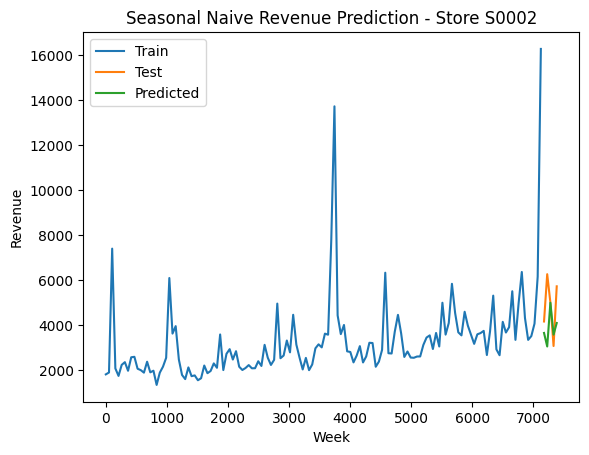

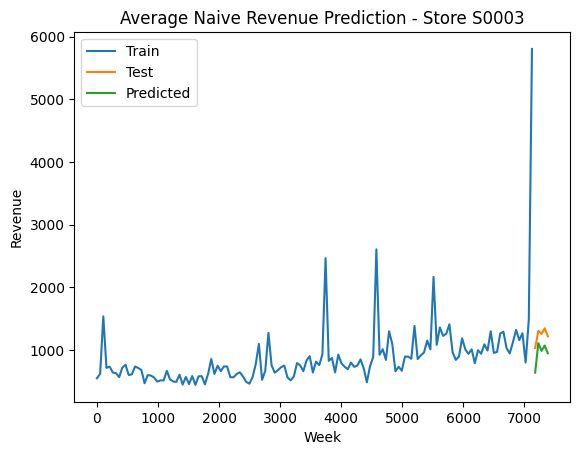

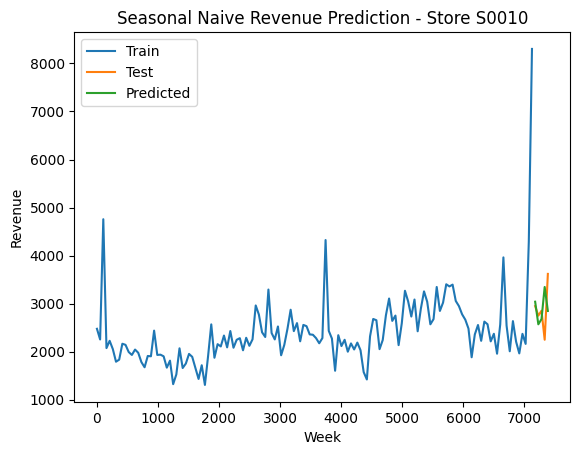

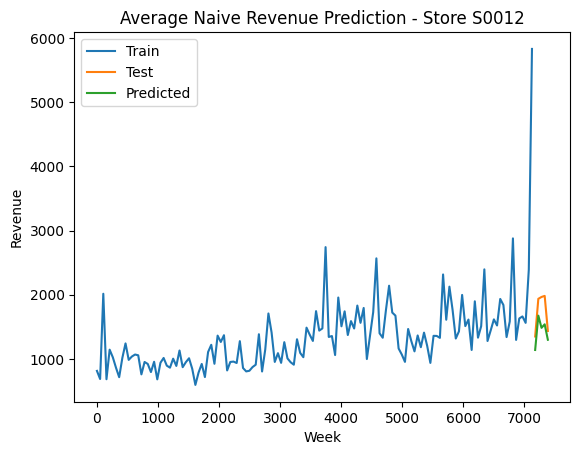

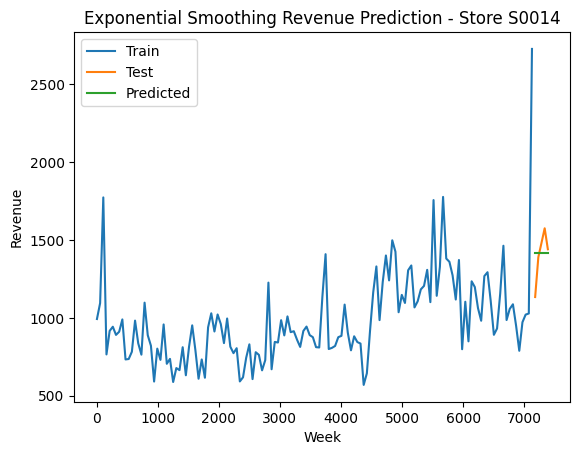

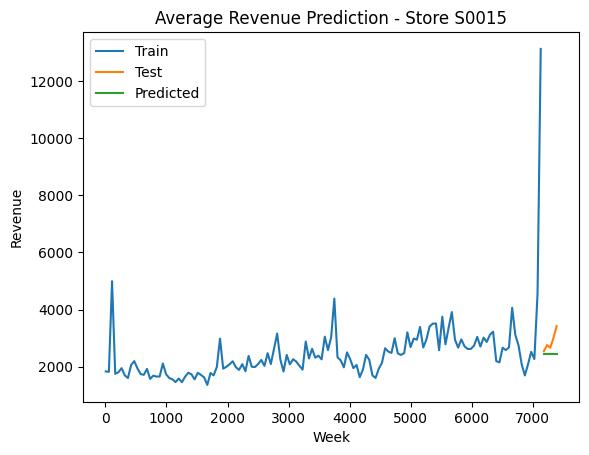

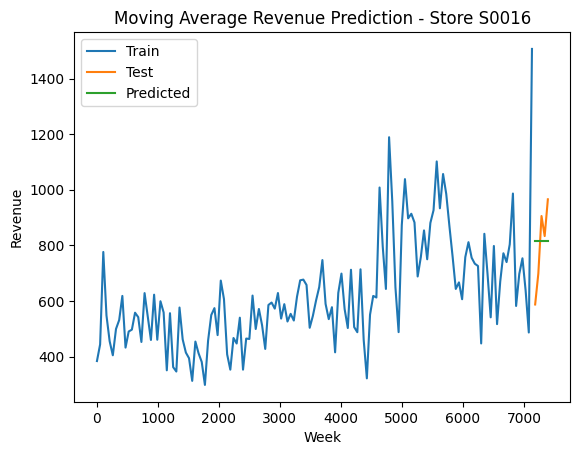

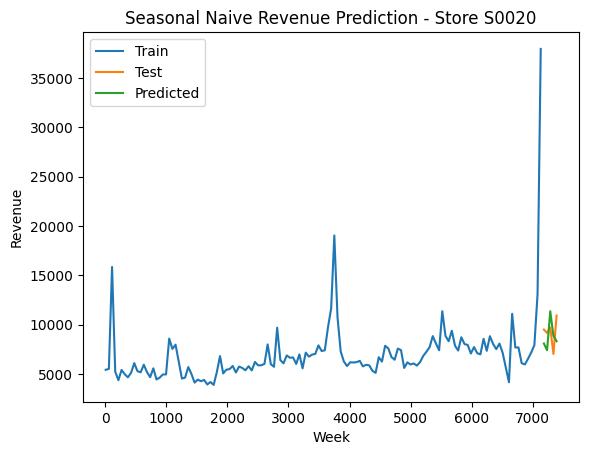

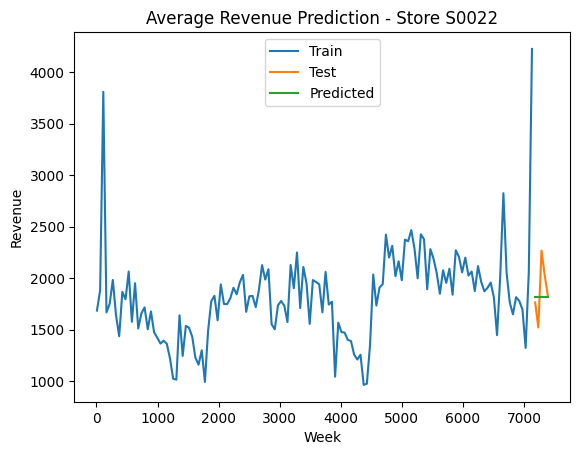

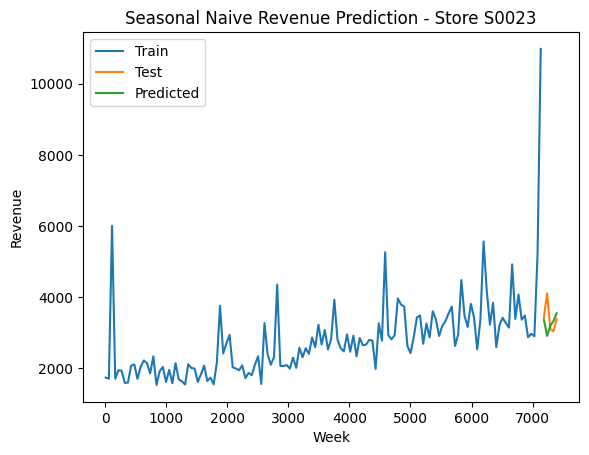

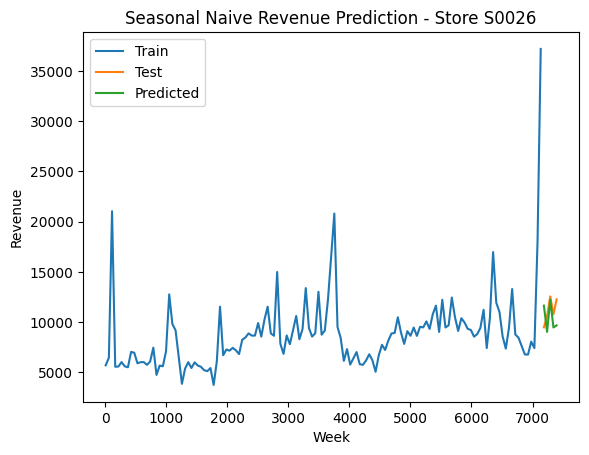

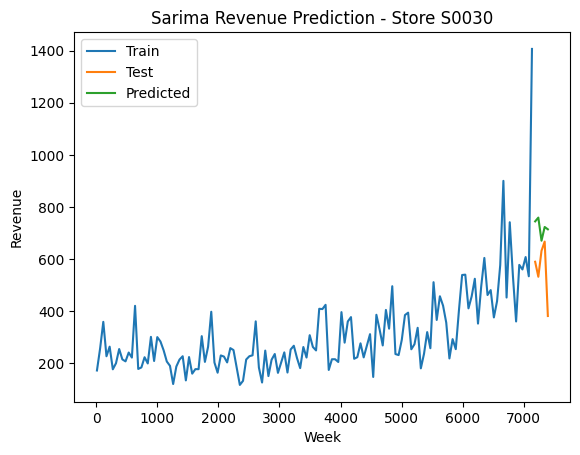

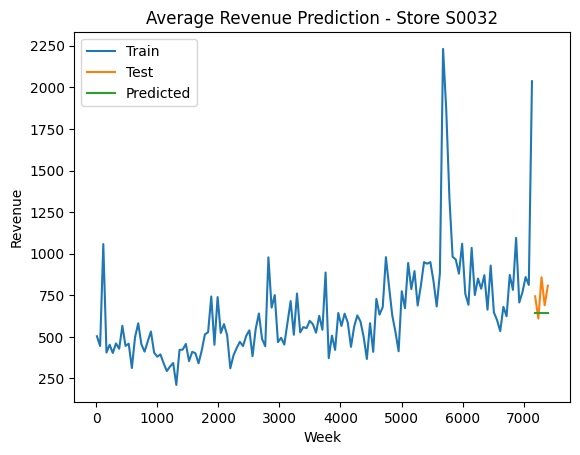

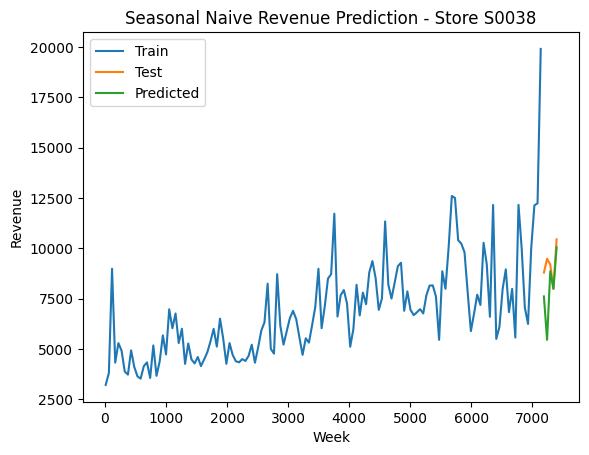

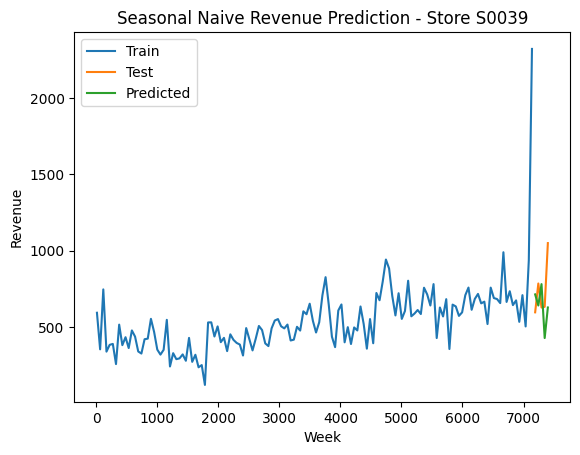

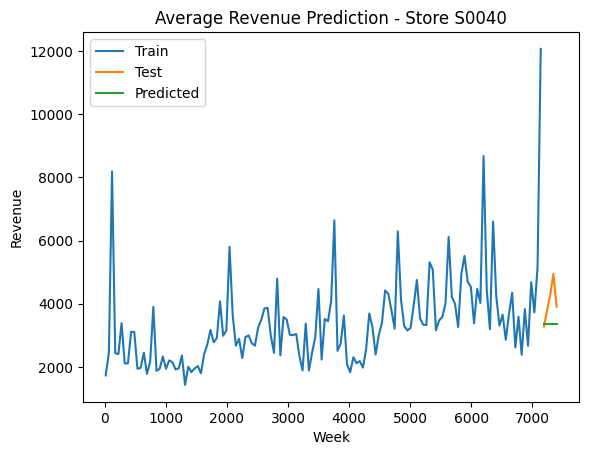

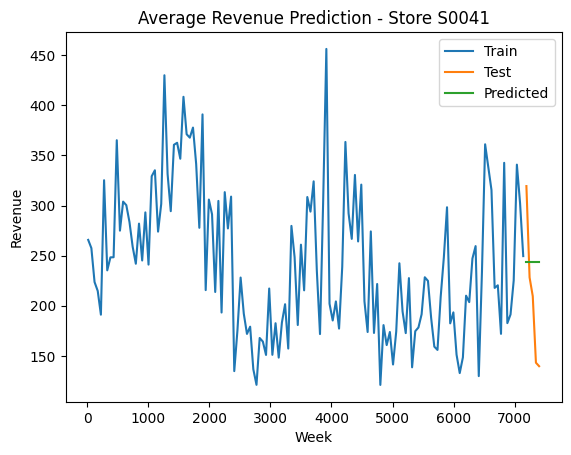

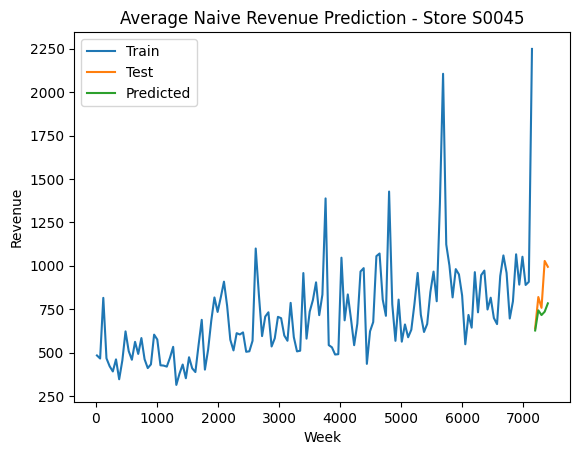

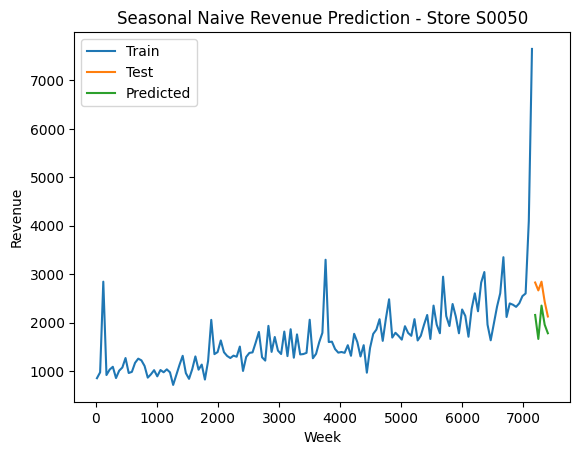

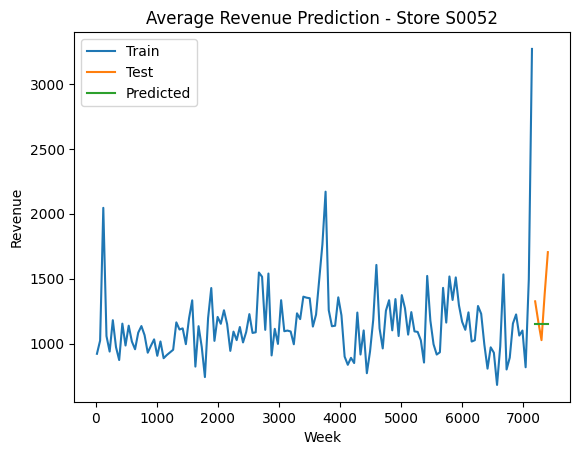

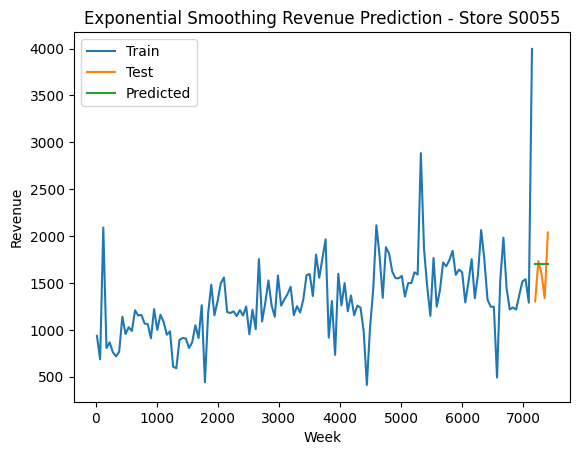

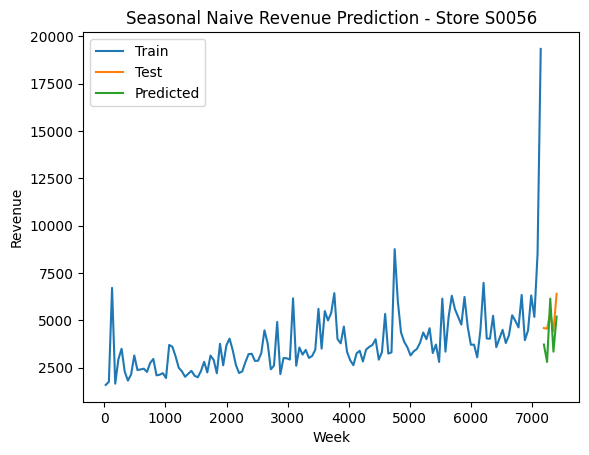

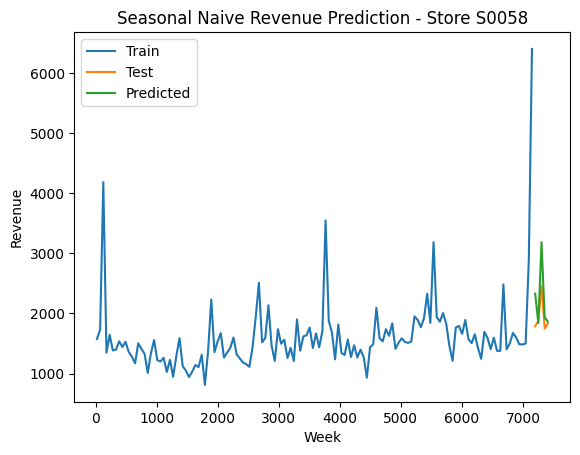

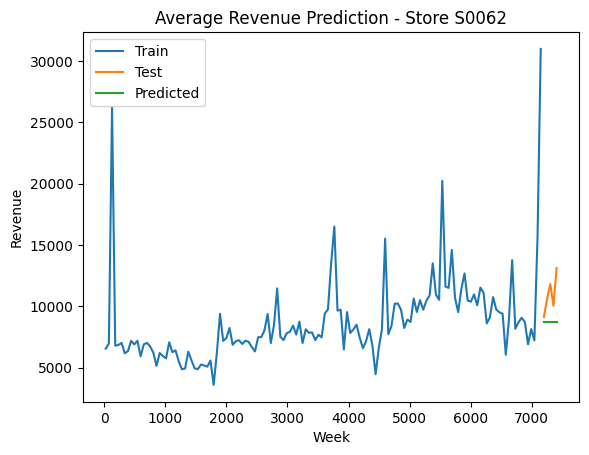

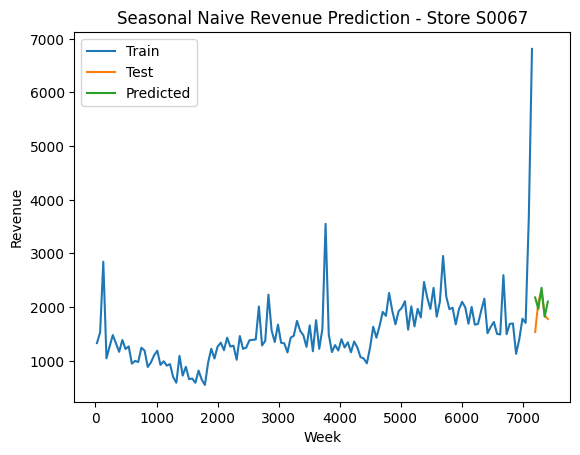

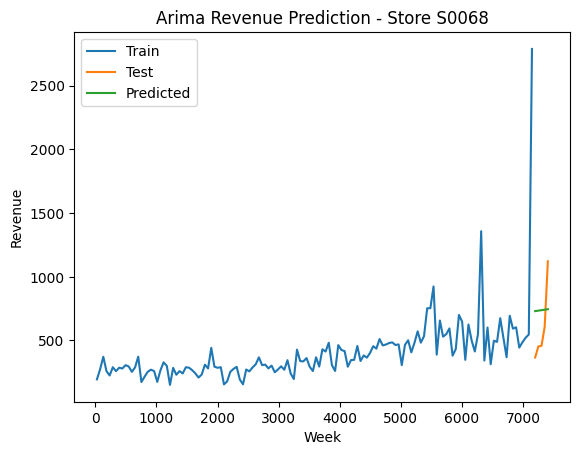

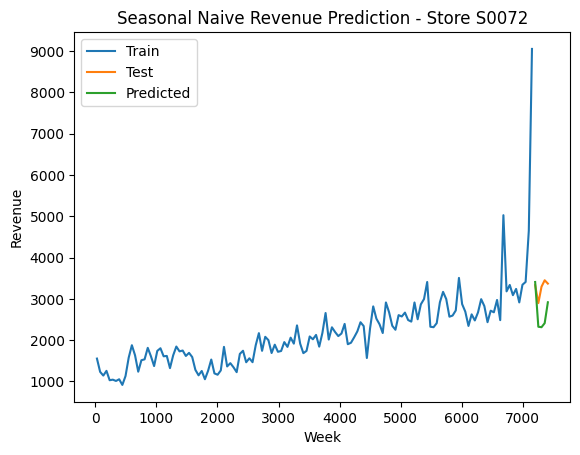

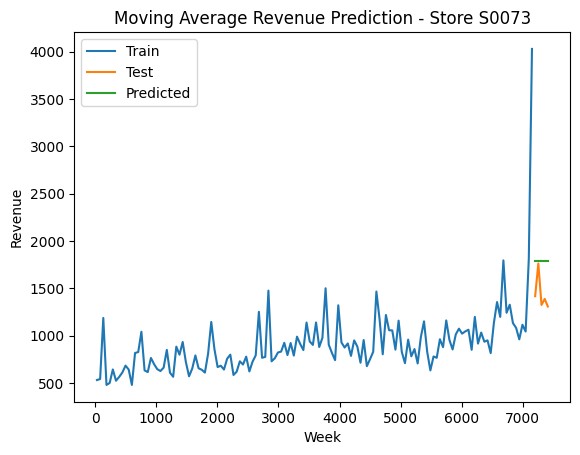

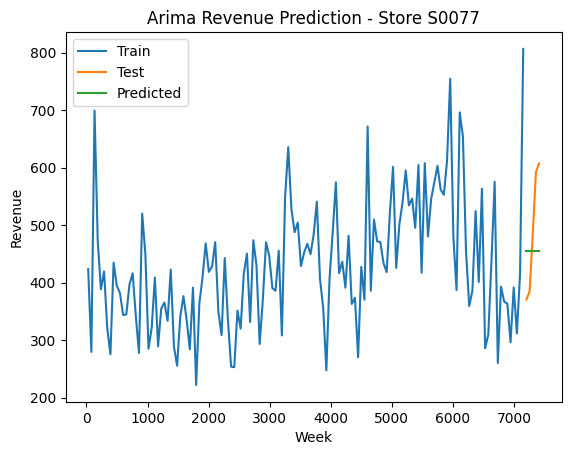

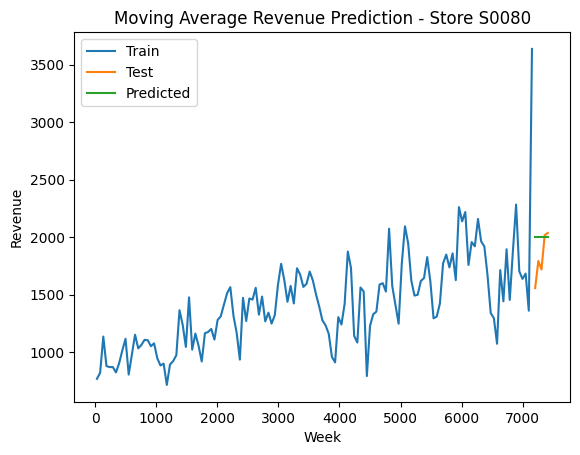

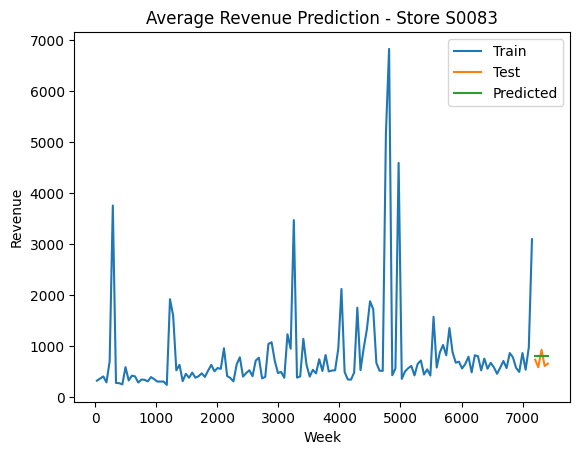

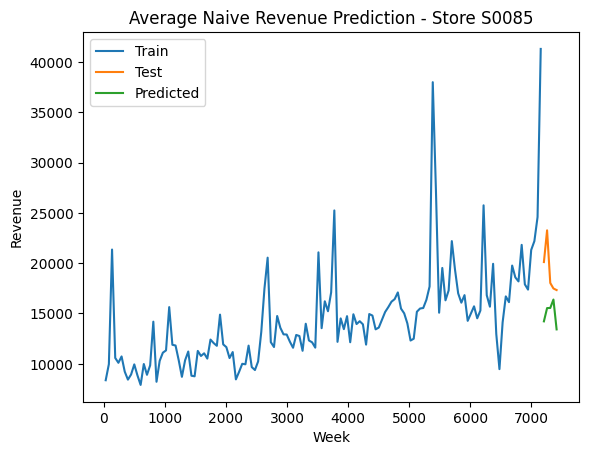

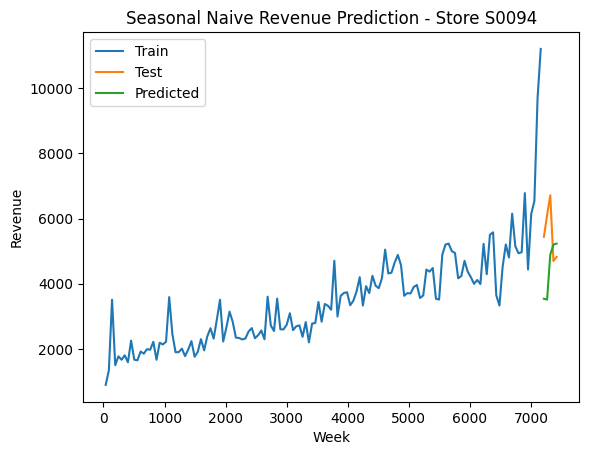

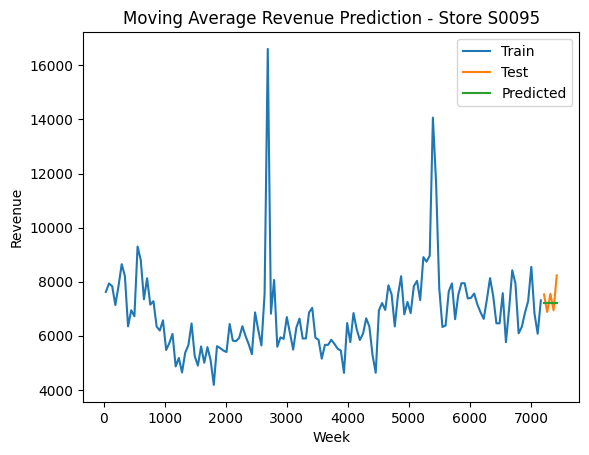

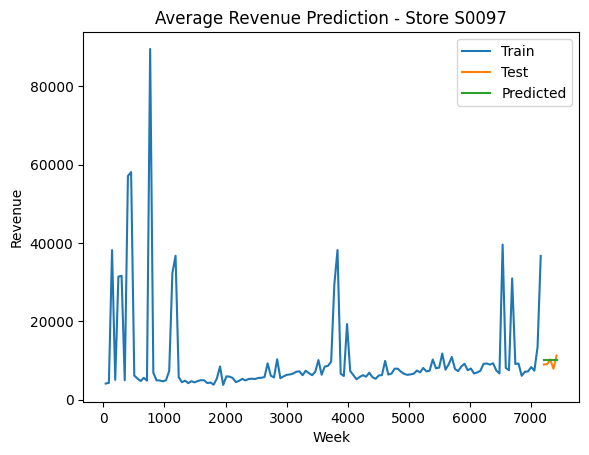

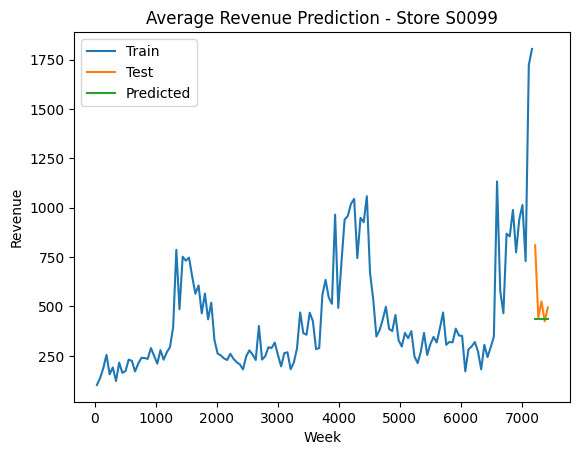

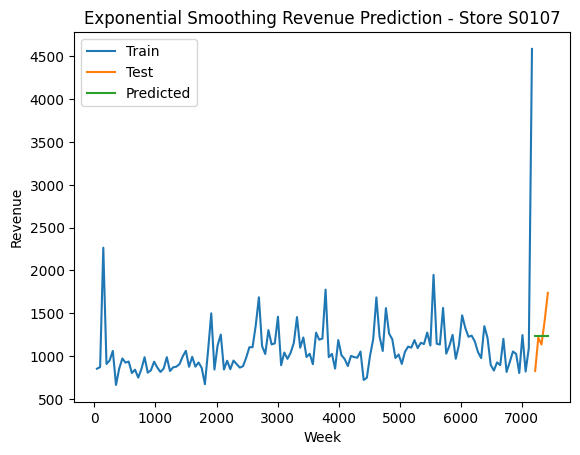

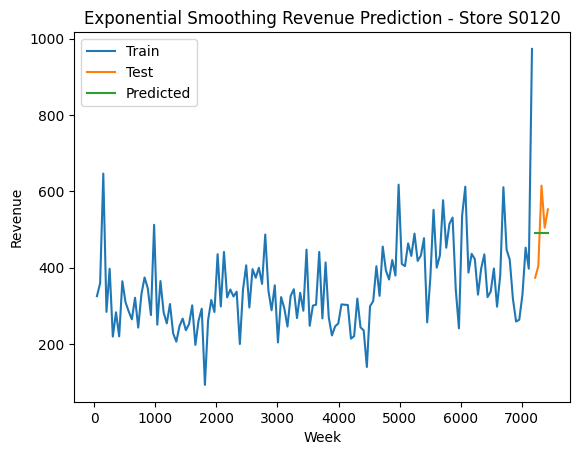

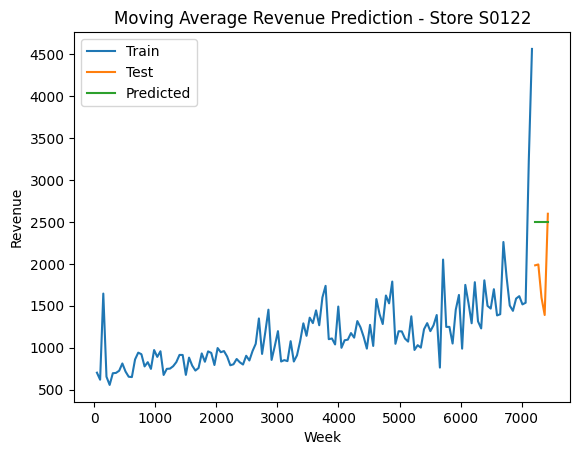

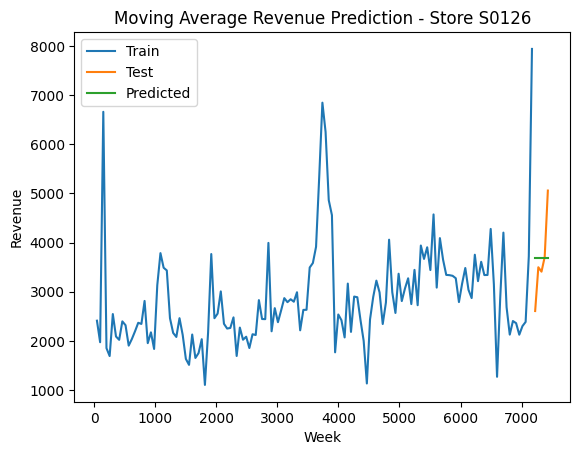

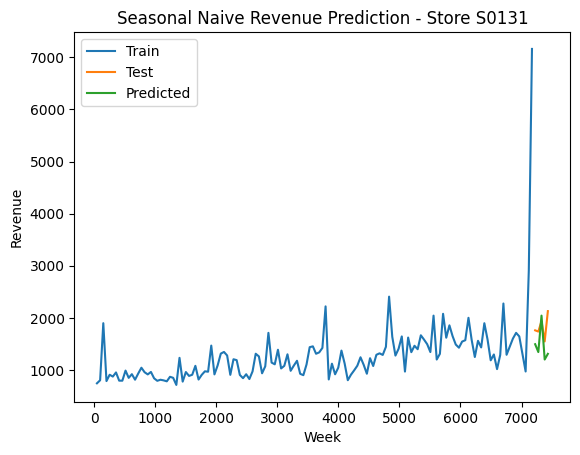

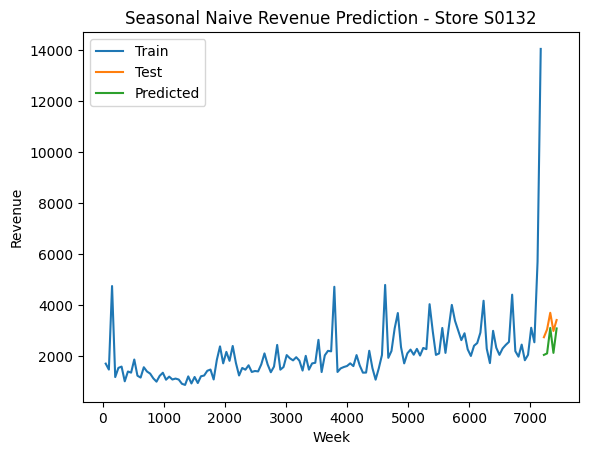

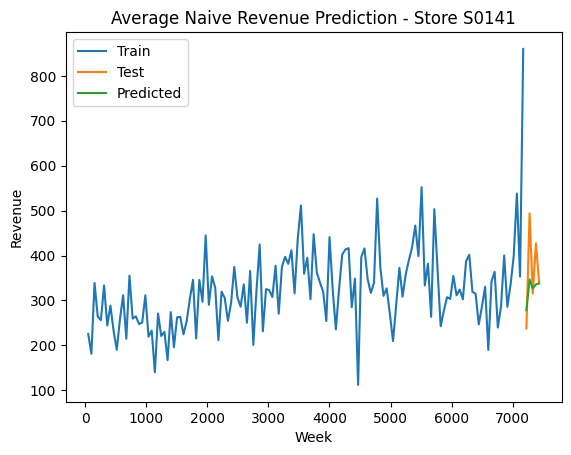

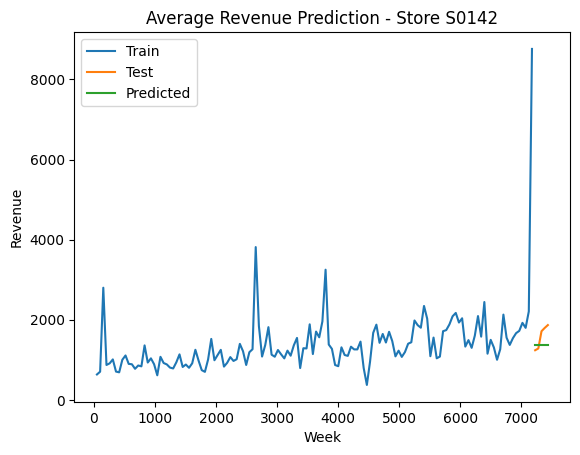

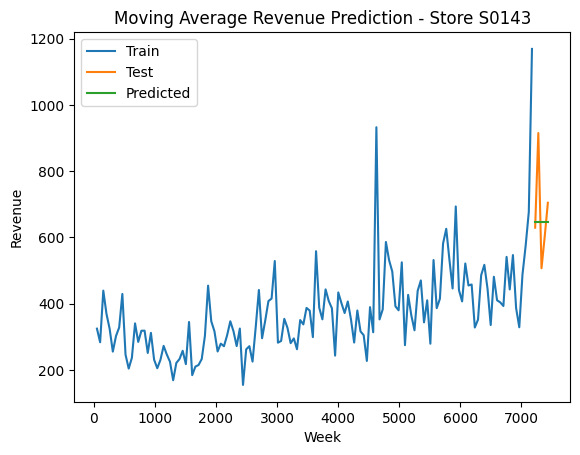

In [243]:
# Step 7: Visualize the results
# If necessary plot only the graphs with the best metrics for each store

for store, store_data in scores_df_final.groupby("store"):
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    
    if scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'seasonal_naive':
        plt.plot(predictions_seasonal_naive.loc[:, store], label='Predicted')
        plt.title(f"Seasonal Naive Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'average':
        plt.plot(predictions_mean.loc[:, store], label='Predicted')
        plt.title(f"Average Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'regression':
        plt.plot(predictions_reg.loc[:, store], label='Predicted')
        plt.title(f"Average Naive Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'moving_avg':
        plt.plot(predictions_moving_avg.loc[:, store], label='Predicted')
        plt.title(f"Moving Average Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'exp_smoothing':
        plt.plot(predictions_exp_smoothing.loc[:, store], label='Predicted')
        plt.title(f"Exponential Smoothing Revenue Prediction - Store {store}")

    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'arima_nom':
    #    plt.plot(predictions_arima_nom.loc[test_data['store_id'] == store, store], label='Predicted')
    #    plt.title(f"Arima_nom Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'arima':
        plt.plot(predictions_arima.loc[test_data['store_id'] == store, store], label='Predicted')
        plt.title(f"Arima Revenue Prediction - Store {store}")

    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'sarima':
        plt.plot(predictions_sarima.loc[test_data['store_id'] == store, store], label='Predicted')
        plt.title(f"Sarima Revenue Prediction - Store {store}")
        
    """
    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'sarimax':
        plt.plot(predictions_sarimax.loc[test_data['store_id'] == store, store], label='Predicted')
        plt.title(f"Sarimax Revenue Prediction - Store {store}")
    """

    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

### Prediction

In [258]:

    #if scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'seasonal_naive':

    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'moving_avg':
   
    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'exp_smoothing':
 
    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'arima_nom':

    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'arima':

    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'sarima':
   
    #elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'sarimax':

predictions = pd.DataFrame()

for store, store_data in prediction.groupby('store_id'):

    if scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'regression':
        Y_train = prediction['revenue']
        X_train = prediction.drop(columns=['revenue', 'date', 'store_id'])  # Drop non-numeric columns
        
        regression_model = LinearRegression()
        regression_model.fit(X_train, Y_train)
        
        y_pred_regression_weeks = []
        
        for _, week_data in X_test.iterrows():
            y_pred_regression = regression_model.predict([week_data])
            y_pred_regression_weeks.append(y_pred_regression)
        
        predictions = predictions.append(pd.DataFrame(np.concatenate(y_pred_regression_weeks), columns=[store]).set_index(future.index))
        
    elif scores_df_final.loc[scores_df_final['store'] == store, 'best_method'].values[0] == 'average':
        y_pred_mean_weeks = []
        Y_train = prediction['revenue']
        mean_target = np.mean(Y_train)
        arr = np.array([1])
        y_pred_mean = np.full_like(arr, mean_target)
        y_pred_mean_weeks.append(y_pred_mean)
        predictions = predictions.append(pd.DataFrame(np.concatenate(y_pred_mean_weeks), columns=[store], index=future.index))


IndentationError: expected an indented block after 'for' statement on line 17 (2007817127.py, line 19)

#### Prepare data

In [41]:
prediction = pd.read_csv("data_to_arima.csv")
future = pd.read_csv("sales.csv")
future = future[future["date"] > "2019-09-29"]
future = future[future["date"] < "2019-11-04"]
future['date'] = pd.to_datetime(future['date'])
future = future.groupby([pd.Grouper(key='date', freq='W-SUN'), 'store_id']).agg({'revenue': 'sum'})
first_index = prediction.index[-1] + 1
future = future.reset_index()
future.index = range(first_index, first_index + len(future))
print(future)


           date store_id  revenue
7436 2019-10-06    S0002   363.20
7437 2019-10-06    S0003   102.82
7438 2019-10-06    S0005   109.61
7439 2019-10-06    S0007    82.13
7440 2019-10-06    S0010   497.80
...         ...      ...      ...
7741 2019-11-03    S0131     0.00
7742 2019-11-03    S0132     0.00
7743 2019-11-03    S0141     0.00
7744 2019-11-03    S0142     0.00
7745 2019-11-03    S0143     0.00

[310 rows x 3 columns]


In [43]:
future['month'] = future.date.dt.month
future['weekofyear'] = future['date'].dt.isocalendar().week
future['is_open'] = 1

season_holidays = pd.read_csv("season_holidays.csv")
season_holidays = season_holidays.rename(columns={'Date': 'date'})
season_holidays['date'] = pd.to_datetime(season_holidays['date'])

# Group by week and create binary columns
season_holidays = season_holidays.groupby(by=pd.Grouper(key='date', freq='W-SUN')).agg({
    'season': lambda x: ','.join(set(x)),
    'Holiday': 'any'
}).reset_index()

# Create binary columns for seasons
season_holidays['IsWinter'] = season_holidays['season'].str.contains('winter').astype(int)
season_holidays['IsSummer'] = season_holidays['season'].str.contains('summer').astype(int)
season_holidays['IsSpring'] = season_holidays['season'].str.contains('spring').astype(int)
season_holidays['IsAutumn'] = season_holidays['season'].str.contains('autumn').astype(int)

# Create binary columns for holidays
season_holidays['IsHoliday'] = season_holidays['Holiday'].astype(int)

# Shift the holiday column by 1 week to get last week's holiday
season_holidays['LastWeekHoliday'] = season_holidays['Holiday'].shift(1).fillna(False).astype(int)

# Shift the holiday column by -1 week to get next week's holiday
season_holidays['NextWeekHoliday'] = season_holidays['Holiday'].shift(-1).fillna(False).astype(int)
season_holidays.drop(['season', 'Holiday'], axis=1, inplace=True)

future = future.merge(season_holidays, on='date', how='left')

print(future)
future.to_csv("future_norm.csv", index=False)

          date store_id  revenue  year  month  weekofyear  is_open  IsWinter  \
0   2019-10-06    S0002   363.20  2019     10          40        1         0   
1   2019-10-06    S0003   102.82  2019     10          40        1         0   
2   2019-10-06    S0005   109.61  2019     10          40        1         0   
3   2019-10-06    S0007    82.13  2019     10          40        1         0   
4   2019-10-06    S0010   497.80  2019     10          40        1         0   
..         ...      ...      ...   ...    ...         ...      ...       ...   
305 2019-11-03    S0131     0.00  2019     11          44        1         0   
306 2019-11-03    S0132     0.00  2019     11          44        1         0   
307 2019-11-03    S0141     0.00  2019     11          44        1         0   
308 2019-11-03    S0142     0.00  2019     11          44        1         0   
309 2019-11-03    S0143     0.00  2019     11          44        1         0   

     IsSummer  IsSpring  IsAutumn  IsHo

#### Predictions

In [ ]:
# Step 8: Predict for the next five weeks, include exogenous variables in the future

predictions = pd.DataFrame()
exogenous_vars = ['month', 'weekofyear', 'is_open', 'IsWinter', 'IsSummer', 
                  'IsSpring', 'IsAutumn', 'IsHoliday', 'LastWeekHoliday', 'NextWeekHoliday']

for store, store_data in prediction.groupby('store_id'):
    best_model = scores_df.loc[scores_df['store_id'] == store, 'best_method'].values[0]

    # Get the corresponding model for the best method
    if best_model == 'arima_nom':
        model = models_arima_nom[store]
    elif best_model == 'arima':
        model = models_arima[store]
    elif best_model == 'sarima':
        model = models_sarima[store]
    elif best_model == 'sarimax':
        model = models_sarimax[store]

    # Fit the model
    model.fit(prediction['revenue'])

    # Define forecast time
    forecast_start_week = prediction[prediction['store_id'] == store]['date'].max() + pd.DateOffset(weeks=1)
    future_weeks = 5

    if best_model == 'sarimax':
        # Here we are adding the exogenous variables that we know for this store
        exogenous_data = future.loc[future['store_id'] == store, exogenous_vars]
        # Predict
        future_forecast = model.predict(n_periods=future_weeks, start=forecast_start_week, exogenous=exogenous_data)
    else:
        future_forecast = model.predict(n_periods=future_weeks, start=forecast_start_week)

    # Save the predictions
    predictions = predictions.append(pd.DataFrame(future_forecast, columns=[store]).set_index(prediction[prediction['store_id'] == store].index))

# Print the predictions
print(predictions)

## Incomplete Data
In this section we are going to focus on the stores without the entire data.

### Data Preparation

In [99]:
# We have separated the data before, so we are going to call it here

stores_remaining = ["S0136"]
df_2 = df_2[~df_2['store_id'].isin(stores_remaining)]

df = df_2.groupby([pd.Grouper(key='date', freq='W-SUN'), 'store_id']).agg({'revenue': 'sum'}).reset_index()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['weekofyear'] = df['date'].dt.isocalendar().week
df['is_open'] = 0
df.loc[df['revenue'] != 0, 'is_open'] = 1

season_holidays = pd.read_csv("season_holidays.csv")
season_holidays = season_holidays.rename(columns={'Date': 'date'})
season_holidays['date'] = pd.to_datetime(season_holidays['date'])

season_holidays = season_holidays.groupby(by=pd.Grouper(key='date', freq='W-SUN')).agg({
    'season': lambda x: ','.join(set(x)),
    'Holiday': 'any'
}).reset_index()

season_holidays['IsWinter'] = season_holidays['season'].str.contains('winter').astype(int)
season_holidays['IsSummer'] = season_holidays['season'].str.contains('summer').astype(int)
season_holidays['IsSpring'] = season_holidays['season'].str.contains('spring').astype(int)
season_holidays['IsAutumn'] = season_holidays['season'].str.contains('autumn').astype(int)

season_holidays['IsHoliday'] = season_holidays['Holiday'].astype(int)

season_holidays['LastWeekHoliday'] = season_holidays['Holiday'].shift(1).fillna(False).astype(int)

season_holidays['NextWeekHoliday'] = season_holidays['Holiday'].shift(-1).fillna(False).astype(int)
season_holidays.drop(['season', 'Holiday'], axis=1, inplace=True)

df = df.merge(season_holidays, on='date', how='left')
df[['revenue']] = df[['revenue']].round(2)

print(df)
df.to_csv("data_to_arima_rest_of_stores.csv", index=False)

test_start_week = df['date'].max() - pd.DateOffset(weeks=5)
print(test_start_week)
train_data = df[df['date'] <= test_start_week]
print(train_data)
test_data = df[df['date'] > test_start_week]
print(test_data)

          date store_id  revenue  month  weekofyear  is_open  IsWinter  \
0   2017-06-04    S0059     0.00      6          22        0         0   
1   2017-06-11    S0059     0.00      6          23        0         0   
2   2017-06-18    S0059     0.00      6          24        0         0   
3   2017-06-25    S0059     0.00      6          25        0         0   
4   2017-07-02    S0059     0.00      7          26        0         0   
..         ...      ...      ...    ...         ...      ...       ...   
743 2019-09-29    S0061  3423.16      9          39        1         0   
744 2019-09-29    S0071  2190.63      9          39        1         0   
745 2019-09-29    S0076  1540.44      9          39        1         0   
746 2019-09-29    S0092  1188.00      9          39        1         0   
747 2019-09-29    S0109  2353.34      9          39        1         0   

     IsSummer  IsSpring  IsAutumn  IsHoliday  LastWeekHoliday  NextWeekHoliday  
0           0         1       

### Simple Models

### Auto (S)arima(x) Weekly (revenue)

In [100]:
#predictions_arima_nom_inc = pd.DataFrame()
predictions_arima_inc = pd.DataFrame()
predictions_sarima_inc = pd.DataFrame()
#predictions_sarimax_inc = pd.DataFrame()

#models_arima_nom_inc = {}
models_arima_inc = {}
models_sarima_inc = {}
#models_sarimax_inc = {}

exogenous_vars_inc = ['month', 'weekofyear', 'is_open', 'IsWinter', 'IsSummer',
                  'IsSpring', 'IsAutumn', 'IsHoliday', 'LastWeekHoliday', 'NextWeekHoliday']
"""
scores_df_inc = pd.DataFrame(columns=['store',
                                  'mae_arima_nom_inc',
                                  'rmse_arima_nom_inc',
                                  'mape_arima_nom_inc',
                                  'mae_arima_inc',
                                  'rmse_arima_inc',
                                  'mape_arima_inc',
                                  'mae_sarima_inc',
                                  'rmse_sarima_inc',
                                  'mape_sarima_inc',
                                  'mae_sarimax_inc',
                                  'rmse_sarimax_inc',
                                  'mape_sarimax_inc',
                                  'mae_ensemble_inc',
                                  'rmse_ensemble_inc',
                                  'mape_ensemble_inc'])
"""
scores_df_inc = pd.DataFrame(columns=['store',
                                  'mae_arima_inc',
                                  'rmse_arima_inc',
                                  'mape_arima_inc',
                                  'mae_sarima_inc',
                                  'rmse_sarima_inc',
                                  'mape_sarima_inc'])

for store, store_data in train_data.groupby('store_id'):
    print(store)
    # Scaling the input data
    scaler_target = MinMaxScaler()
    #scaler_exogenous = MinMaxScaler()

    scaled_train_data = scaler_target.fit_transform(store_data[['revenue']])
    #scaled_train_exogenous = scaler_exogenous.fit_transform(store_data[exogenous_vars])
    
    testing_data = test_data[test_data['store_id'] == store]
    scaled_test_data = scaler_target.transform(testing_data[['revenue']])
    #scaled_test_exogenous = scaler_exogenous.transform(testing_data[exogenous_vars])

    # Models arima, sarima and sarimax
    #model_arima_nom_inc = auto_arima(scaled_train_data[:, 0], random=True, random_state=42, stepwise=True)
    model_arima_inc = auto_arima(scaled_train_data[:, 0], m=52, seasonal=False, random=True, random_state=42, stepwise=True,
                             start_p=1, start_q=1, max_d=4)
    model_sarima_inc = auto_arima(scaled_train_data[:, 0], m=52, seasonal=True, random=True, random_state=42, stepwise=True, 
                              start_p=1, start_q=1, start_P=0, start_Q=0, max_d=4, with_intercept="auto", trend="ct")
    """
    model_sarimax_inc = auto_arima(scaled_train_data[:, 0], exogenous=scaled_train_exogenous, m=52, seasonal=True,
                               start_p=1, start_q=1, start_P=0, start_Q=0, max_d=4, random=True, random_state=42, stepwise=True,
                               with_intercept="auto", trend="ct")
    """

    # Save the best models
    #models_arima_nom_inc[store] = model_arima_nom_inc
    models_arima_inc[store] = model_arima_inc
    models_sarima_inc[store] = model_sarima_inc
    #models_sarimax_inc[store] = model_sarimax_inc

    # Fit the models
    #model_arima_nom_inc.fit(scaled_train_data[:, 0])
    model_arima_inc.fit(scaled_train_data[:, 0])
    model_sarima_inc.fit(scaled_train_data[:, 0])
    #model_sarimax_inc.fit(scaled_train_data[:, 0], exogenous=scaled_train_exogenous)

    # Predict
    #future_forecast_arima_nom_inc = model_arima_nom_inc.predict(n_periods=len(testing_data))
    future_forecast_arima_inc = model_arima_inc.predict(n_periods=len(testing_data))
    future_forecast_sarima_inc = model_sarima_inc.predict(n_periods=len(testing_data))
    #future_forecast_sarimax_inc = model_sarimax_inc.predict(n_periods=len(testing_data), exogenous=scaled_test_exogenous)

    # Inverse scaling of predictions
    #inverse_predictions_arima_nom_inc = scaler_target.inverse_transform(future_forecast_arima_nom_inc.reshape(-1, 1))
    inverse_predictions_arima_inc = scaler_target.inverse_transform(future_forecast_arima_inc.reshape(-1, 1))
    inverse_predictions_sarima_inc = scaler_target.inverse_transform(future_forecast_sarima_inc.reshape(-1, 1))
    #inverse_predictions_sarimax_inc = scaler_target.inverse_transform(future_forecast_sarimax_inc.reshape(-1, 1))

    # Save the inverse scaled predictions
    """
    predictions_arima_nom_inc = predictions_arima_nom_inc.append(pd.DataFrame(inverse_predictions_arima_nom_inc[:, 0], columns=[store])
                                                       .set_index(testing_data.index))
    """
    predictions_arima_inc = predictions_arima_inc.append(pd.DataFrame(inverse_predictions_arima_inc[:, 0], columns=[store])
                                                 .set_index(testing_data.index))
    predictions_sarima_inc = predictions_sarima_inc.append(pd.DataFrame(inverse_predictions_sarima_inc[:, 0], columns=[store])
                                                   .set_index(testing_data.index))
    """
    predictions_sarimax_inc = predictions_sarimax_inc.append(pd.DataFrame(inverse_predictions_sarimax_inc[:, 0], columns=[store])
                                                     .set_index(testing_data.index))
    """
    #print(predictions_arima_nom_inc)
    #print(predictions_arima_inc)
    #print(predictions_sarima_inc)
    #print(predictions_sarimax_inc)

    # Step 5: Evaluate the models performances
    actual_revenue = testing_data['revenue'].values

    """
    mae_arima_nom = mean_absolute_error(actual_revenue, inverse_predictions_arima_nom_inc[:, 0])
    rmse_arima_nom = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_arima_nom_inc[:, 0]))
    mape_arima_nom = (abs((actual_revenue - inverse_predictions_arima_nom_inc[:, 0]) / actual_revenue)).mean() * 100
    """

    mae_arima = mean_absolute_error(actual_revenue, inverse_predictions_arima_inc[:, 0])
    rmse_arima = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_arima_inc[:, 0]))
    mape_arima = (abs((actual_revenue - inverse_predictions_arima_inc[:, 0]) / actual_revenue)).mean() * 100

    mae_sarima = mean_absolute_error(actual_revenue, inverse_predictions_sarima_inc[:, 0])
    rmse_sarima = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_sarima_inc[:, 0]))
    mape_sarima = (abs((actual_revenue - inverse_predictions_sarima_inc[:, 0]) / actual_revenue)).mean() * 100

    """
    mae_sarimax = mean_absolute_error(actual_revenue, inverse_predictions_sarimax_inc[:, 0])
    rmse_sarimax = np.sqrt(mean_squared_error(actual_revenue, inverse_predictions_sarimax_inc[:, 0]))
    mape_sarimax = (abs((actual_revenue - inverse_predictions_sarimax_inc[:, 0]) / actual_revenue)).mean() * 100
    
    scores_df_inc = scores_df_inc.append({'store': store,
                                  'mae_arima_nom_inc': mae_arima_nom_inc,
                                  'rmse_arima_nom_inc': rmse_arima_nom_inc,
                                  'mape_arima_nom_inc': mape_arima_nom_inc,
                                  'mae_arima_inc': mae_arima_inc,
                                  'rmse_arima_inc': rmse_arima_inc,
                                  'mape_arima_inc': mape_arima_inc,
                                  'mae_sarima_inc': mae_sarima_inc,
                                  'rmse_sarima_inc': rmse_sarima_inc,
                                  'mape_sarima_inc': mape_sarima_inc,
                                  'mae_sarimax_inc': mae_sarimax_inc,
                                  'rmse_sarimax_inc': rmse_sarimax_inc,
                                  'mape_sarimax_inc': mape_sarimax_inc}, ignore_index=True)
    """

    scores_df_inc = scores_df_inc.append({'store': store,
                                  'mae_arima_inc': mae_arima_inc,
                                  'rmse_arima_inc': rmse_arima_inc,
                                  'mape_arima_inc': mape_arima_inc,
                                  'mae_sarima_inc': mae_sarima_inc,
                                  'rmse_sarima_inc': rmse_sarima_inc,
                                  'mape_sarima_inc': mape_sarima_inc,}, ignore_index=True)
    print(scores_df)

### Saving

In [101]:
predictions_arima_inc.to_csv("predictions_arima_inc.csv")
predictions_sarima_inc.to_csv("predictions_sarima_inc.csv")
predictions_sarimax_inc.to_csv("predictions_sarimax_inc.csv")
scores_df_inc.to_csv("scores_df_inc.csv")

# Specify the file path to save the CSV
csv_file_path_arima_inc = "models_arima_inc.csv"  
csv_file_path_sarima_inc = "models_sarima_inc.csv"
csv_file_path_sarimax_inc = "models_sarimax_inc.csv"

# Prepare the data for writing to CSV
csv_data_arima_inc = []
csv_data_sarima_inc = []
csv_data_sarimax_inc = []

for store, model in models_arima_inc.items():
    model_data_arima_inc = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_arima_inc.append(model_data_arima_inc)

with open(csv_file_path_arima_inc, mode="w", newline="") as csv_file_arima_inc:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_arima_inc, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_arima_inc)

for store, model in models_sarima_inc.items():
    model_data_sarima_inc = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_sarima_inc.append(model_data_sarima_inc)

with open(csv_file_path_sarima_inc, mode="w", newline="") as csv_file_sarima_inc:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_sarima_inc, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_sarima_inc)

for store, model in models_sarimax_inc.items():
    model_data_sarimax_inc = {
        "store": store,
        "model_params": model.to_dict()
    }
    csv_data_sarimax_inc.append(model_data_sarimax_inc)

with open(csv_file_path_sarimax_inc, mode="w", newline="") as csv_file_sarimax_inc:
    fieldnames = ["store", "model_params"]
    writer = csv.DictWriter(csv_file_sarimax_inc, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write the data rows
    writer.writerows(csv_data_sarimax_inc)

### Best Model

### Graphs for training and test data

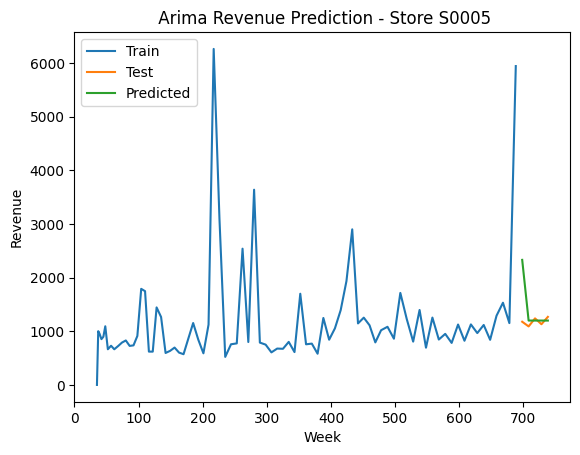

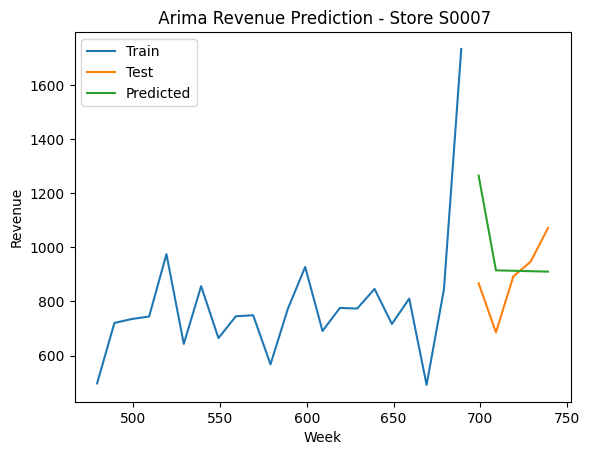

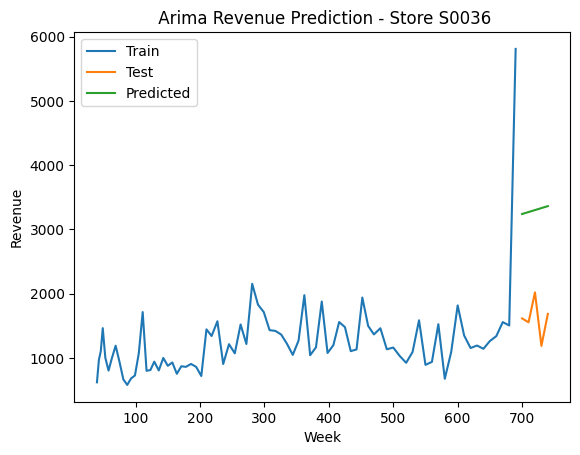

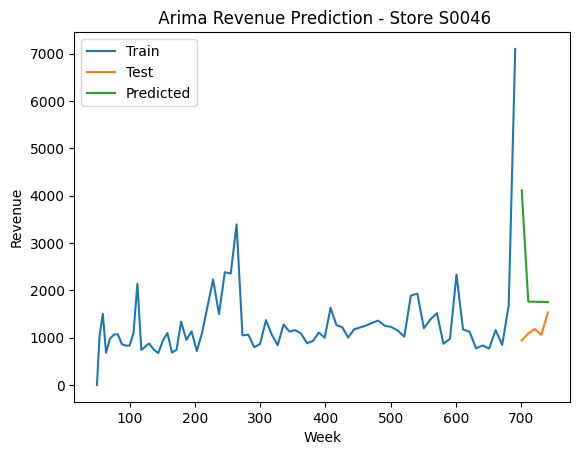

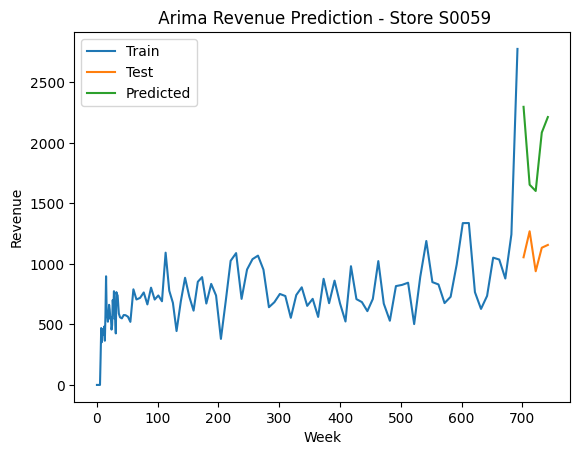

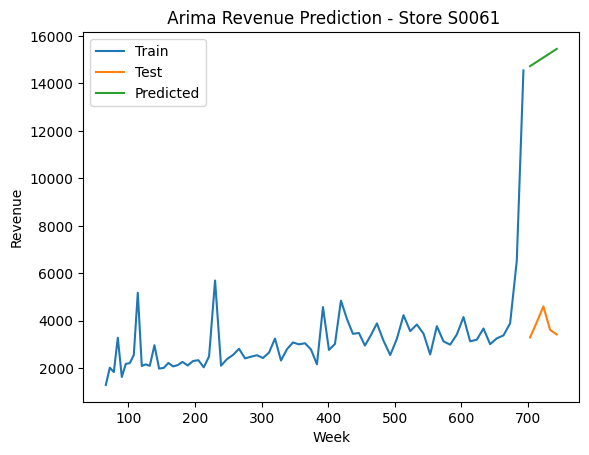

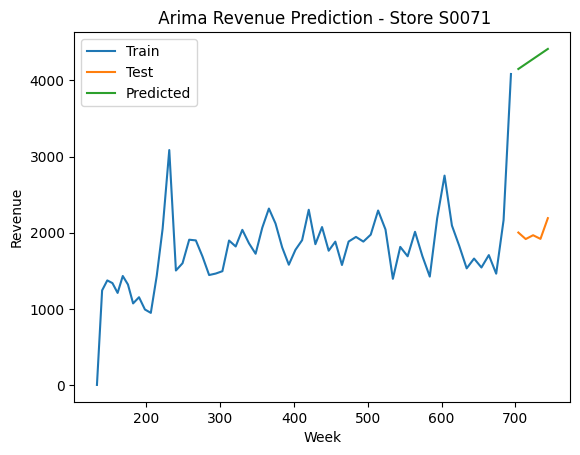

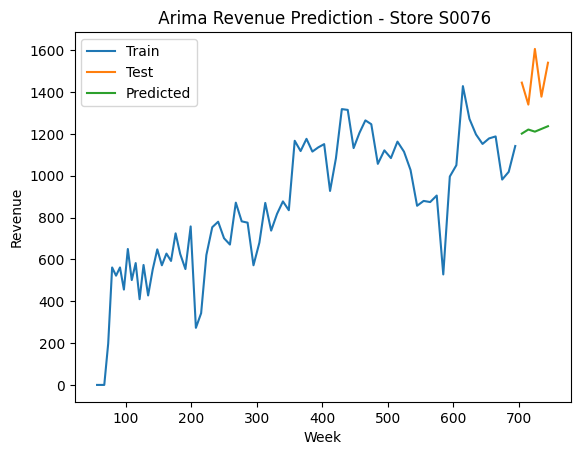

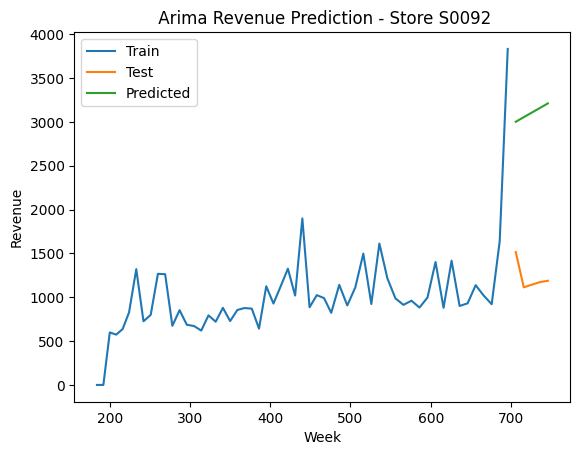

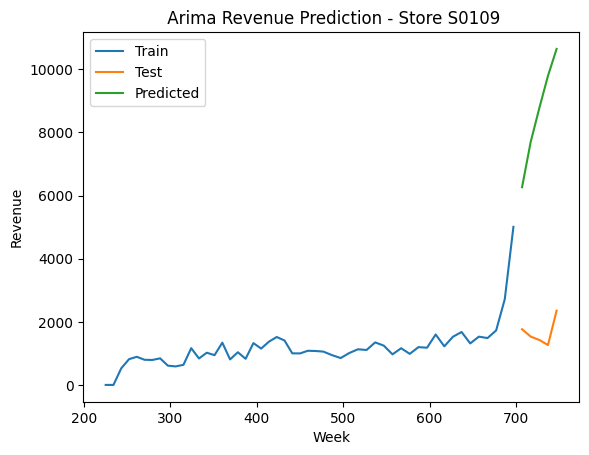

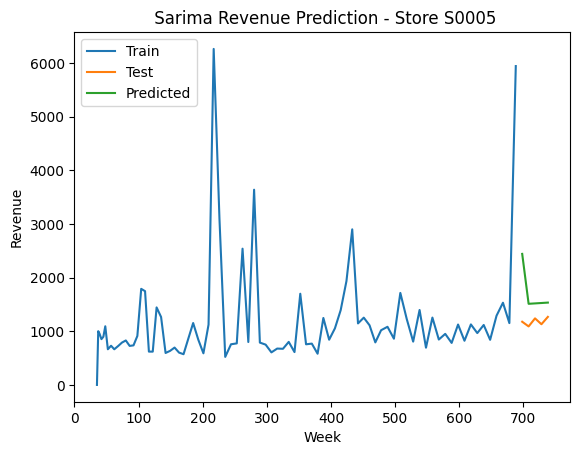

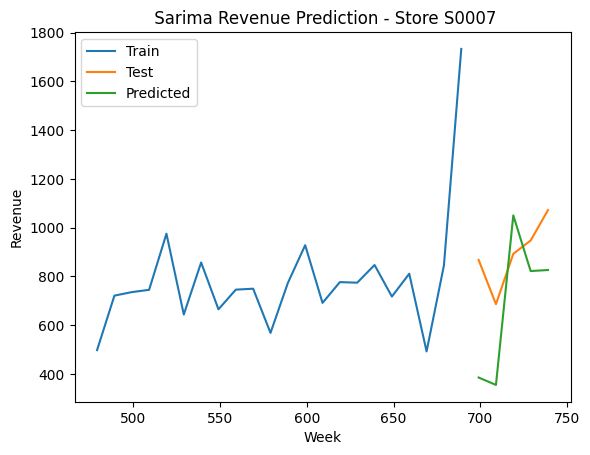

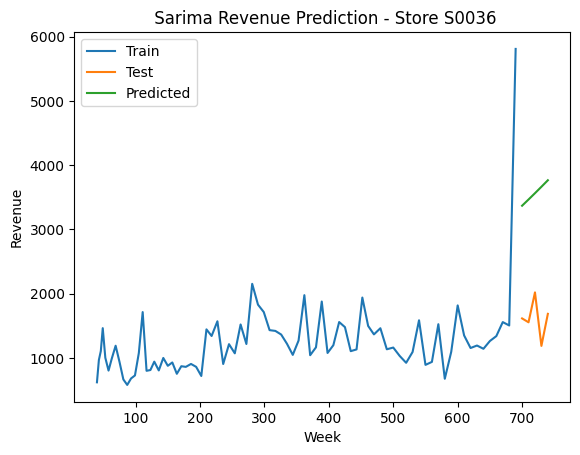

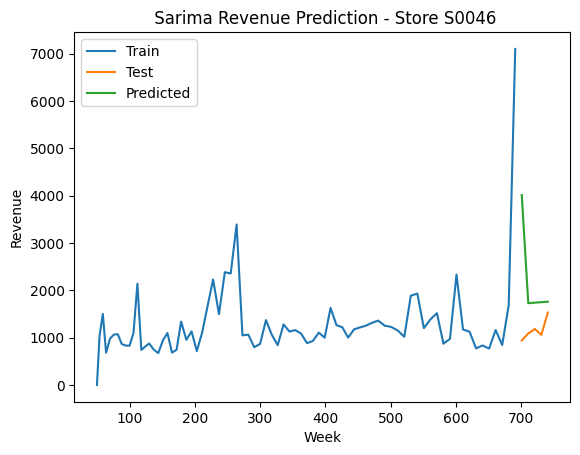

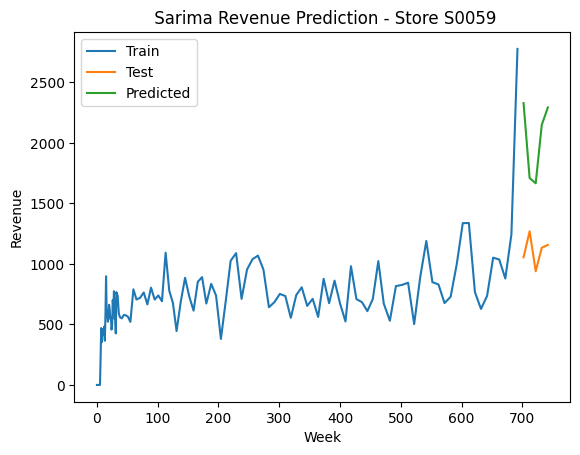

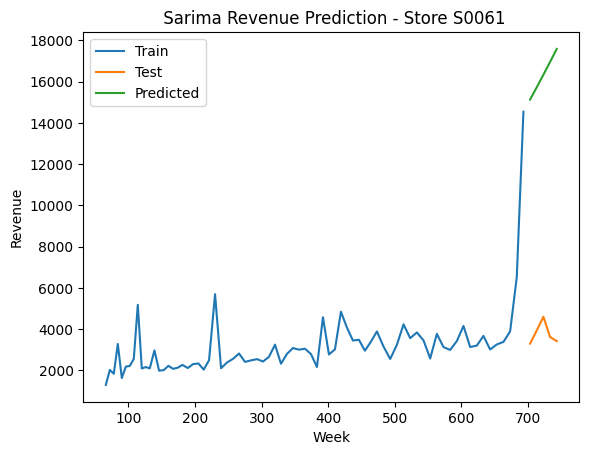

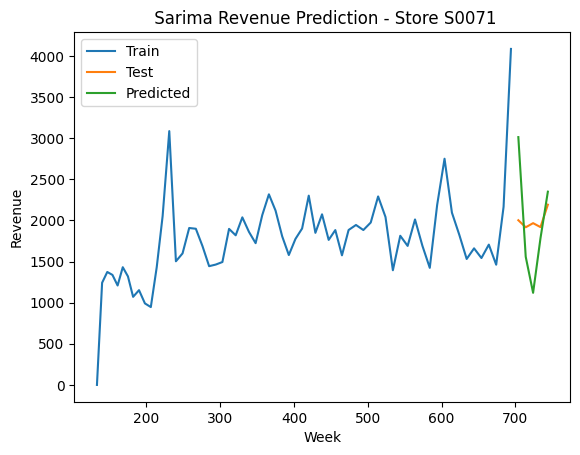

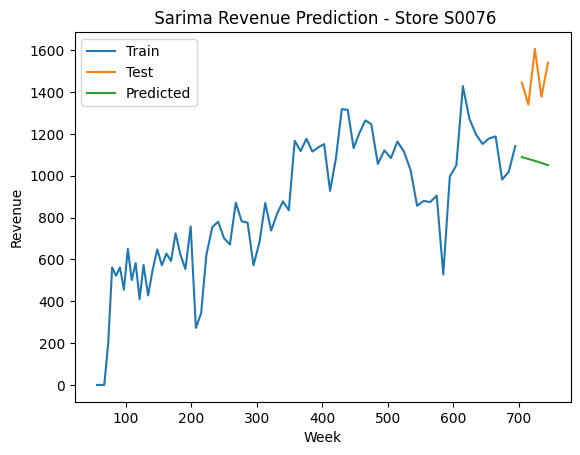

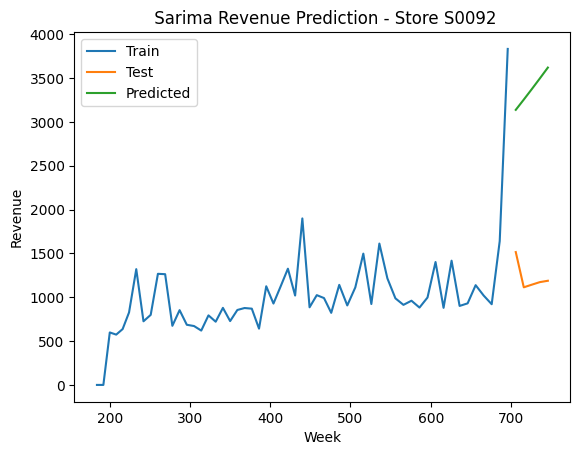

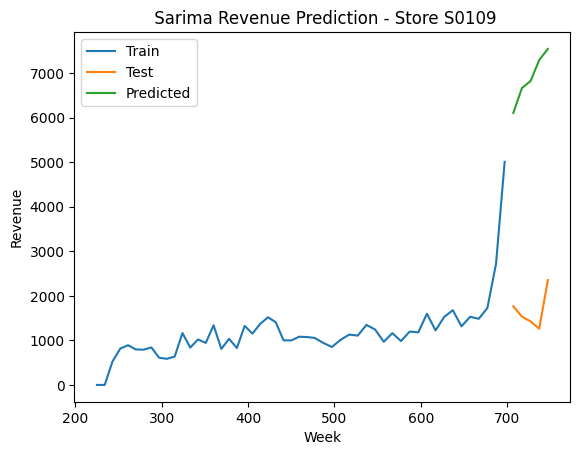

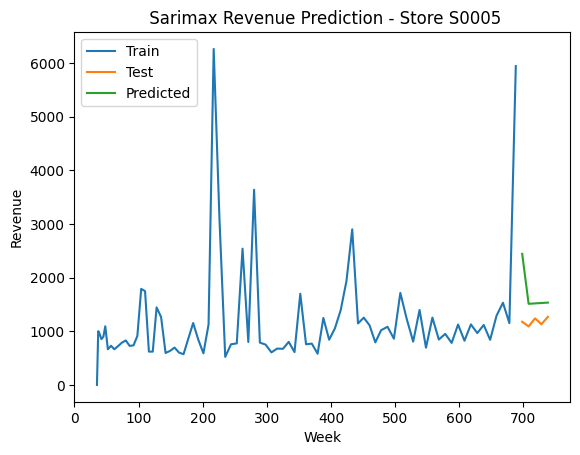

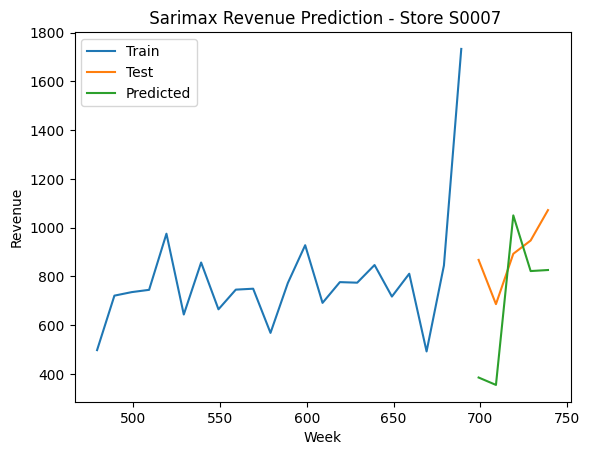

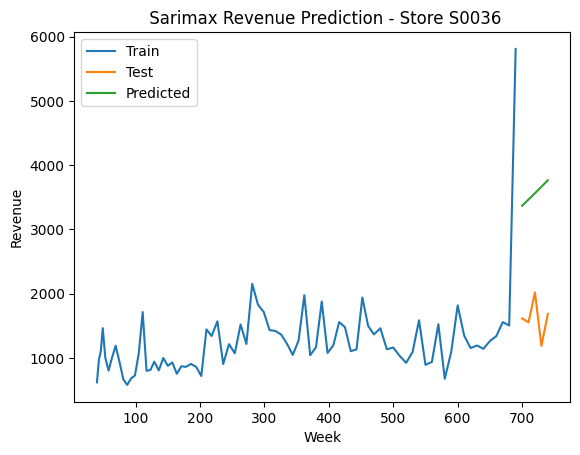

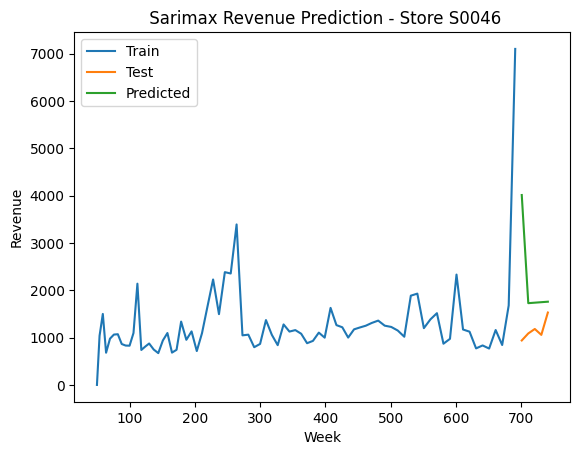

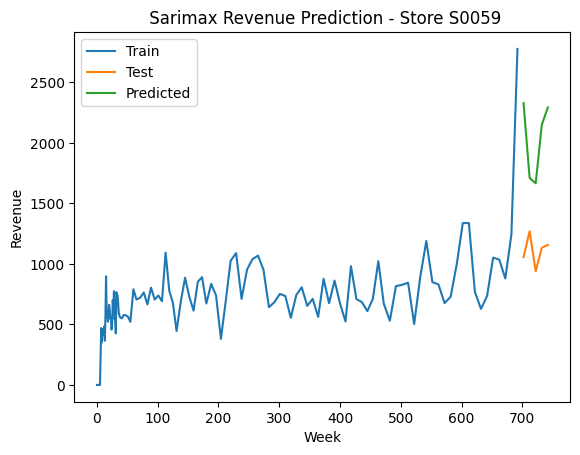

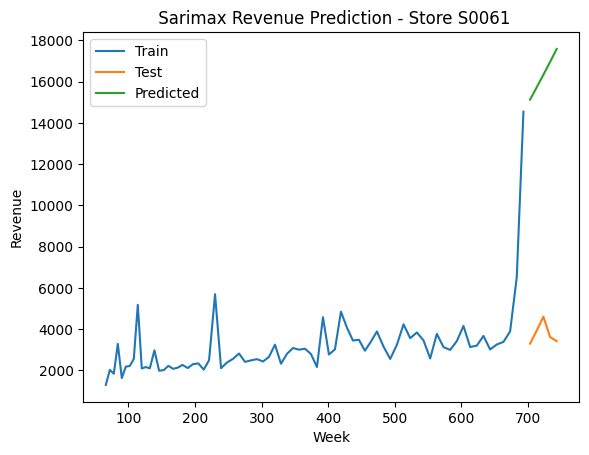

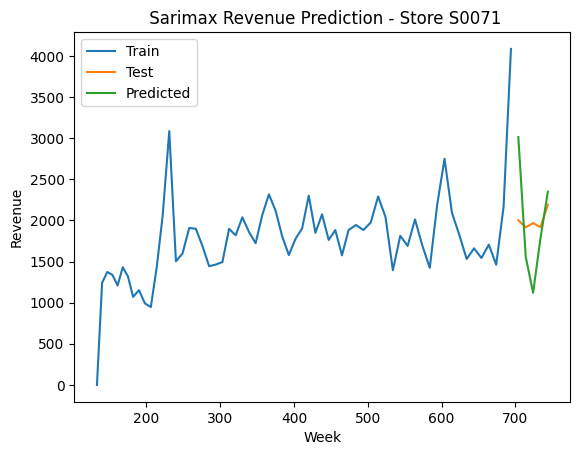

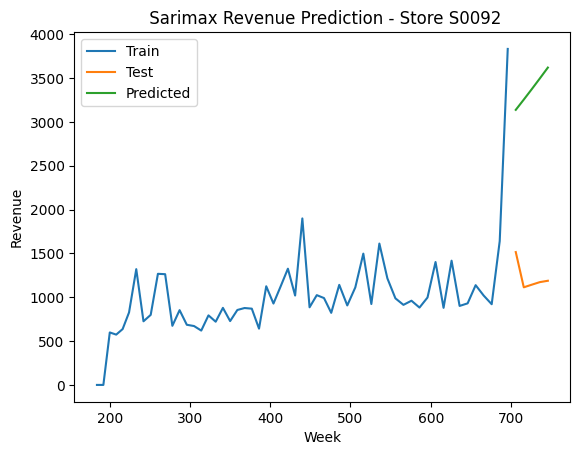

In [102]:
for store in predictions_arima_inc.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_arima_inc.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f" Arima Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

for store in predictions_sarima_inc.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_sarima_inc.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f" Sarima Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

for store in predictions_sarimax_inc.columns:
    plt.figure()
    plt.plot(train_data[train_data['store_id'] == store]['revenue'], label='Train')
    plt.plot(test_data[test_data['store_id'] == store]['revenue'], label='Test')
    plt.plot(predictions_sarimax_inc.loc[test_data['store_id'] == store, store], label='Predicted')
    plt.title(f" Sarimax Revenue Prediction - Store {store}")
    plt.xlabel("Week")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

### Predictions